<a href="https://colab.research.google.com/github/Ehtisham1053/Demand-Forecasting-using-ML/blob/main/Demand_frecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm



In [2]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/Final Year Project/models")

In [5]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv")
holidays = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")

In [23]:
list1 = [train , stores , transactions , holidays , oil]
for i in list1:
  print(i.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dayofweek', 'year'],
      dtype='object')
Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object')
Index(['date', 'store_nbr', 'transactions'], dtype='object')
Index(['date', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred'],
      dtype='object')
Index(['date', 'oil_price'], dtype='object')


## Analyzing the train dataset

1. Daily Sales Over Time

In [7]:

daily_sales = train.groupby('date')['sales'].sum().reset_index()
fig = px.line(daily_sales, x='date', y='sales', title='Daily Sales Over Timeline of 6 months',
              color_discrete_sequence=['#FF6F61'])
fig.show()


This graph visualizes the overall trend of sales over time, highlighting any seasonal patterns, peaks, or dips.

## 2. Monthly Average Sales by Store Type

In [8]:
store_type_sales = train.merge(stores, on='store_nbr')
# Convert 'date' column to datetime
store_type_sales['date'] = pd.to_datetime(store_type_sales['date'])
monthly_type_sales = store_type_sales.groupby([pd.Grouper(key='date', freq='M'), 'type'])['sales'].mean().reset_index()
fig = px.line(monthly_type_sales, x='date', y='sales', color='type', title='Monthly Average Sales by Store Type',
              color_discrete_sequence=px.colors.qualitative.Vivid)
fig.show()

<ipython-input-8-da4bda56ff92>:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



This graph shows seasonal sales trends for each store type, making it easier to identify which store types perform better during different months.

## 3. Correlation Between Oil Prices and Sales

In [9]:
oil = oil.rename(columns={'dcoilwtico': 'oil_price'})
oil['oil_price'] = oil['oil_price'].ffill()
sales_oil = train.merge(oil, on='date', how='left')
daily_sales_oil = sales_oil.groupby('date')[['sales', 'oil_price']].sum().reset_index()
fig = px.scatter(daily_sales_oil, x='oil_price', y='sales', trendline='ols',
                 title='Correlation between Oil Prices and Total Sales',
                 color_discrete_sequence=['#6A5ACD'])
fig.show()


## 4. 30-Day Moving Averages for Sales and Oil Prices

In [10]:
window_size = 30
daily_sales_oil['sales_ma'] = daily_sales_oil['sales'].rolling(window=window_size).mean()
daily_sales_oil['oil_price_ma'] = daily_sales_oil['oil_price'].rolling(window=window_size).mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales_oil['date'], y=daily_sales_oil['sales_ma'],
                         name='30-day MA Sales', line=dict(color='#2E8B57')))
fig.add_trace(go.Scatter(x=daily_sales_oil['date'], y=daily_sales_oil['oil_price_ma'],
                         name='30-day MA Oil Price', line=dict(color='#FFA07A')))
fig.update_layout(title='30-day Moving Average of Sales and Oil Prices',
                  xaxis_title='Date', yaxis_title='Value')
fig.show()


Moving averages help smooth out short-term fluctuations to highlight overall trends.

## 5. Holiday Impact on Sales by Store Type

In [11]:
holidays = holidays.rename(columns={'type': 'holiday_type'})
store_type_sales = train.merge(stores, on='store_nbr')
holiday_sales = store_type_sales.merge(holidays[['date', 'holiday_type']], on='date', how='left')
holiday_sales['is_holiday'] = holiday_sales['holiday_type'].notna()

holiday_impact_store = holiday_sales.groupby(['type', 'is_holiday'])['sales'].mean().reset_index()
holiday_impact_store['is_holiday'] = holiday_impact_store['is_holiday'].map({True: 'Holiday', False: 'Non-Holiday'})

fig = px.bar(holiday_impact_store, x='type', y='sales', color='is_holiday', barmode='group',
             title='Impact of Holidays on Sales by Store Type',
             color_discrete_sequence=['#FF6347', '#4682B4'],
             labels={'type': 'Store Type', 'sales': 'Average Sales', 'is_holiday': 'Holiday Status'})
fig.show()


## 6. Sales Around Holidays (3-Day Window)

In [12]:

def get_sales_window(date, window=3):

    date = pd.to_datetime(date)
    start_date = date - pd.Timedelta(days=window)
    end_date = date + pd.Timedelta(days=window)
    return start_date, end_date

holiday_dates = holidays['date'].unique()
holiday_windows = []
for date in holiday_dates:
    start_date, end_date = get_sales_window(date)
    window_sales = train[(train['date'] >= start_date.strftime('%Y-%m-%d')) & (train['date'] <= end_date.strftime('%Y-%m-%d'))].copy()
    window_sales['days_from_holiday'] = (pd.to_datetime(window_sales['date']) - pd.to_datetime(date)).dt.days
    holiday_windows.append(window_sales)

holiday_effect = pd.concat(holiday_windows)
daily_effect = holiday_effect.groupby('days_from_holiday')['sales'].mean().reset_index()

fig = px.line(daily_effect, x='days_from_holiday', y='sales',
              title='Average Sales Around Holidays',
              labels={'days_from_holiday': 'Days from Holiday', 'sales': 'Average Sales'})
fig.add_vline(x=0, line_dash="dash", line_color="red")
fig.show()

## 7. Average Sales by Holiday Type

In [13]:

sales_holiday_type = train.merge(holidays[['date', 'holiday_type']], on='date', how='left')
holiday_sales_avg = sales_holiday_type.groupby('holiday_type')['sales'].mean().reset_index()

fig = px.bar(holiday_sales_avg, x='holiday_type', y='sales', title='Average Sales by Holiday Type',
             color_discrete_sequence=px.colors.qualitative.Safe)
fig.show()


##  8. Transaction Volume Over Time

In [14]:
daily_trans = transactions.groupby('date')['transactions'].sum().reset_index()
fig = px.line(daily_trans, x='date', y='transactions', title='Daily Transaction Volume Over Time',
              color_discrete_sequence=['#20B2AA'])
fig.show()


Tracks customer transaction activity over time, revealing trends in customer visits and buying patterns.

## 9. Transaction Density Analysis

In [15]:

trans_density = transactions.groupby('store_nbr').agg(
    mean_trans=('transactions', 'mean'),
    total_trans=('transactions', 'sum'),
    trans_days=('transactions', 'count')).reset_index()

fig = px.histogram(trans_density, x='mean_trans', title='Distribution of Average Daily Transactions per Store',
                   color_discrete_sequence=['#6495ED'])
fig.show()


## 10. Weekly Sales Seasonality

In [16]:
train['date'] = pd.to_datetime(train['date'])
train['dayofweek'] = train['date'].dt.dayofweek
daily_pattern = train.groupby('dayofweek')['sales'].mean().reset_index()
daily_pattern['dayofweek'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = px.bar(daily_pattern, x='dayofweek', y='sales', title='Average Daily Sales Pattern',
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.show()

## 11. Lag Analysis Between Oil Prices and Sales


In [17]:
max_lag = 30
lag_correlations = [daily_sales_oil['sales'].corr(daily_sales_oil['oil_price'].shift(lag)) for lag in range(max_lag)]
fig = px.line(x=list(range(max_lag)), y=lag_correlations,
              title='Lag Analysis: Oil Prices vs Sales',
              labels={'x': 'Lag (days)', 'y': 'Correlation'},
              color_discrete_sequence=['#DC143C'])
fig.show()


This graph shows how sales respond to changes in oil prices with a delay. A high correlation at a specific lag (e.g., 5 days) suggests that sales are affected by changes in oil prices after that number of days.

## 12. Sales Volatility Over Time

In [18]:

window_sizes = [7, 30, 90]

for window in window_sizes:
    daily_sales_oil[f'sales_volatility_{window}'] = daily_sales_oil['sales'].rolling(window=window).std()

fig = go.Figure()
for window in window_sizes:
    fig.add_trace(go.Scatter(
        x=daily_sales_oil['date'],
        y=daily_sales_oil[f'sales_volatility_{window}'],
        name=f'{window}-day Volatility'
    ))

fig.update_layout(title='Sales Volatility Over Different Time Windows',
                  xaxis_title='Date', yaxis_title='Volatility (Standard Deviation)')
fig.show()


## 13. Yearly Sales and Growth Rate

In [19]:

train['year'] = train['date'].dt.year
yearly_sales = train.groupby('year')['sales'].sum().reset_index()
yearly_sales['growth'] = yearly_sales['sales'].pct_change()


fig = go.Figure()
fig.add_trace(go.Bar(x=yearly_sales['year'], y=yearly_sales['sales'], name='Total Sales'))
fig.add_trace(go.Scatter(x=yearly_sales['year'], y=yearly_sales['growth'], name='Growth Rate (%)',
                         yaxis='y2'))

fig.update_layout(
    title='Yearly Sales and Growth Rate',
    yaxis=dict(title='Total Sales'),
    yaxis2=dict(title='Growth Rate (%)', overlaying='y', side='right'),
    showlegend=True
)
fig.show()


## 14. Store Type vs. Holiday Type Interaction

In [20]:
holiday_sales = store_type_sales.merge(holidays[['date', 'holiday_type']], on='date', how='left')
interaction_sales = holiday_sales.groupby(['type', 'holiday_type'])['sales'].mean().reset_index()

fig = px.bar(interaction_sales, x='type', y='sales', color='holiday_type', barmode='group',
             title='Sales by Store Type and Holiday Type',
             labels={'type': 'Store Type', 'sales': 'Average Sales', 'holiday_type': 'Holiday Type'})
fig.show()


## 15. Seasonal Decomposition of Sales

In [21]:
daily_sales = train.groupby('date')['sales'].sum().reset_index()
daily_sales.set_index('date', inplace=True)

decomposition = sm.tsa.seasonal_decompose(daily_sales['sales'], period=365, model='additive')

fig = make_subplots(rows=4, cols=1, subplot_titles=['Original Sales', 'Trend Component', 'Seasonal Component', 'Residuals'])
fig.add_trace(go.Scatter(x=daily_sales.index, y=daily_sales['sales'], name='Original'), row=1, col=1)
fig.add_trace(go.Scatter(x=daily_sales.index, y=decomposition.trend, name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=daily_sales.index, y=decomposition.seasonal, name='Seasonality'), row=3, col=1)
fig.add_trace(go.Scatter(x=daily_sales.index, y=decomposition.resid, name='Residuals'), row=4, col=1)

fig.update_layout(height=1000, title='Seasonal Decomposition of Sales')
fig.show()


* Trend: Long-term direction of sales growth.
* Seasonal: Repeating patterns in sales (e.g., weekends, months).
* Residuals: Random fluctuations not explained by trend or seasonality.

## 17. Monthly Transaction Volatility

In [ ]:
daily_trans = transactions.groupby('date')['transactions'].sum().reset_index()
daily_trans['trans_pct_change'] = daily_trans['transactions'].pct_change()

daily_trans['date'] = pd.to_datetime(daily_trans['date'])

volatility = daily_trans.groupby(pd.Grouper(key='date', freq='M'))['trans_pct_change'].std().reset_index()

fig = px.line(volatility, x='date', y='trans_pct_change',
              title='Monthly Transaction Volatility',
              labels={'trans_pct_change': 'Transaction Volatility'})
fig.show()

<ipython-input-33-1679ae655449>:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



## 18. Anomaly Detection Using Z-Score

In [ ]:

from scipy.stats import zscore
daily_sales['z_score'] = zscore(daily_sales['sales'].fillna(0))
threshold = 3
anomalies = daily_sales[np.abs(daily_sales['z_score']) > threshold]
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales.index, y=daily_sales['sales'], mode='lines', name='Daily Sales'))
fig.add_trace(go.Scatter(x=anomalies.index, y=anomalies['sales'], mode='markers', name='Anomalies', marker=dict(color='red', size=8)))

fig.update_layout(title='Anomaly Detection in Sales using Z-Score',
                  xaxis_title='Date', yaxis_title='Sales')
fig.show()


Detects unusual spikes or drops in sales using the Z-score method. Data points that fall outside a specified threshold (e.g., beyond 3 standard deviations) are marked as anomalies.

## 19. Anomaly Detection Using IQR (Interquartile Range)

In [ ]:
Q1 = daily_sales['sales'].quantile(0.25)
Q3 = daily_sales['sales'].quantile(0.75)
IQR = Q3 - Q1

anomalies_iqr = daily_sales[(daily_sales['sales'] < (Q1 - 1.5 * IQR)) | (daily_sales['sales'] > (Q3 + 1.5 * IQR))]

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales.index, y=daily_sales['sales'], mode='lines', name='Daily Sales'))
fig.add_trace(go.Scatter(x=anomalies_iqr.index, y=anomalies_iqr['sales'], mode='markers', name='Anomalies (IQR)', marker=dict(color='orange', size=8)))

fig.update_layout(title='Anomaly Detection in Sales using IQR',
                  xaxis_title='Date', yaxis_title='Sales')
fig.show()


## 20. Rolling Statistics for Anomaly Detection

In [ ]:
rolling_mean = daily_sales['sales'].rolling(window=30).mean()
rolling_std = daily_sales['sales'].rolling(window=30).std()

anomalies_rolling = daily_sales[(daily_sales['sales'] > (rolling_mean + 2 * rolling_std)) | (daily_sales['sales'] < (rolling_mean - 2 * rolling_std))]

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales.index, y=daily_sales['sales'], mode='lines', name='Daily Sales'))
fig.add_trace(go.Scatter(x=daily_sales.index, y=rolling_mean, mode='lines', name='Rolling Mean', line=dict(color='green')))
fig.add_trace(go.Scatter(x=anomalies_rolling.index, y=anomalies_rolling['sales'], mode='markers', name='Anomalies (Rolling)', marker=dict(color='red', size=8)))

fig.update_layout(title='Anomaly Detection Using Rolling Statistics',
                  xaxis_title='Date', yaxis_title='Sales')
fig.show()


## 21. Anomaly Detection Across Days of the Week

In [ ]:
anomalies_rolling['day_of_week'] = anomalies_rolling.index.dayofweek
daywise_anomalies = anomalies_rolling['day_of_week'].value_counts(normalize=True).sort_index() * 100

fig = px.bar(x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
             y=daywise_anomalies,
             title='Percentage of Anomalies by Day of Week',
             labels={'x': 'Day of Week', 'y': 'Percentage of Anomalies'},
             color_discrete_sequence=['#9370DB'])
fig.show()


<ipython-input-37-92be93bcc280>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 22. Transactions vs. Sales Efficiency

In [ ]:
transactions['date'] = pd.to_datetime(transactions['date'])


sales_trans = transactions.merge(train, on=['date', 'store_nbr'], how='left')
sales_trans = transactions.merge(train, on=['date', 'store_nbr'], how='left')
sales_trans['sales_per_transaction'] = sales_trans['sales'] / sales_trans['transactions']

avg_sales_trans = sales_trans.groupby('store_nbr')['sales_per_transaction'].mean().reset_index()
fig = px.scatter(avg_sales_trans, x='store_nbr', y='sales_per_transaction',
                 title='Average Sales per Transaction by Store',
                 color_discrete_sequence=['#6A5ACD'])
fig.show()

# Model building and testing of the model

<ipython-input-49-8eb74e79ea98>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8fxa__u/zuj0psc0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu8fxa__u/tuvvfdbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28120', 'data', 'file=/tmp/tmpu8fxa__u/zuj0psc0.json', 'init=/tmp/tmpu8fxa__u/tuvvfdbm.json', 'output', 'file=/tmp/tmpu8fxa__u/prophet_model9fcbvkh9/prophet_model-20250223192723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:27:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:27:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-51-d419c855157f>:45: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from 

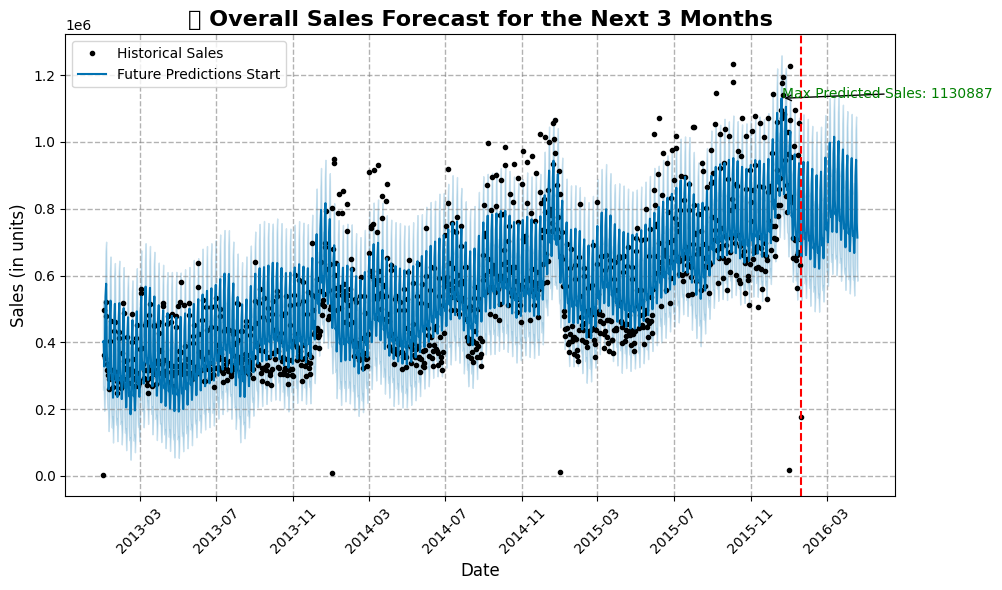

Root Mean Square Error (RMSE): 21.82


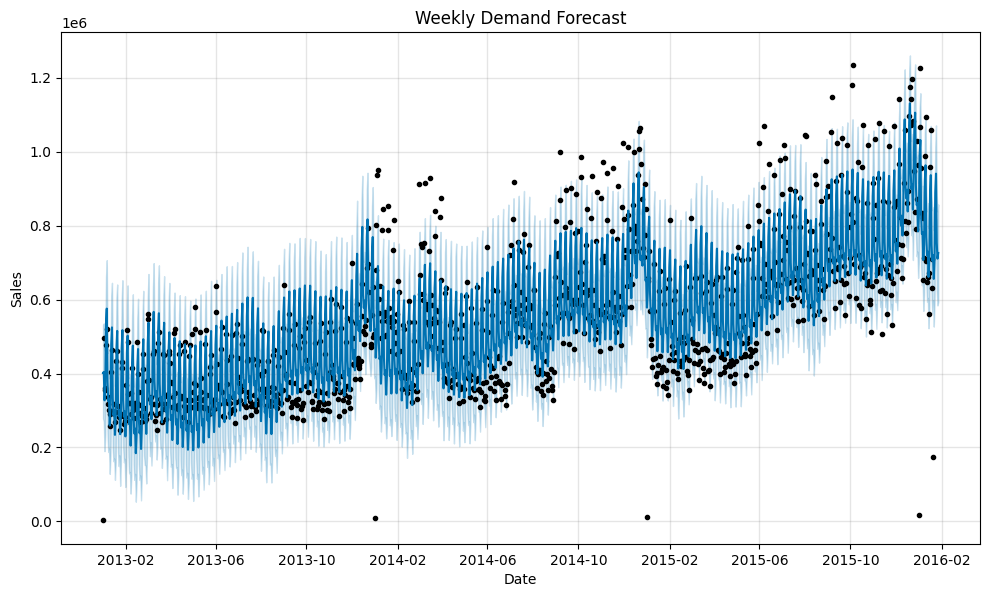

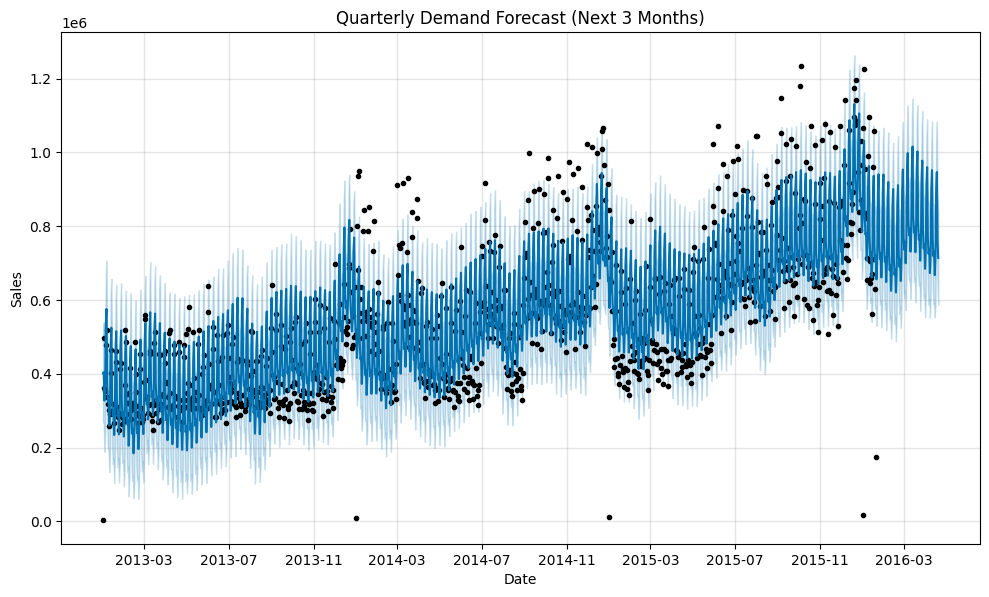

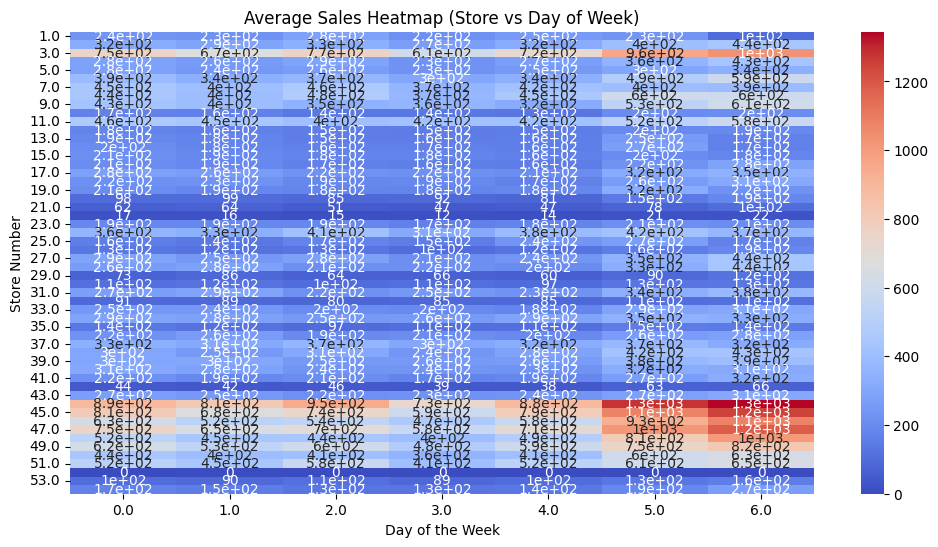

# using the XGBOOST model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Merge the datasets
full_data = train.merge(stores, on='store_nbr', how='left') \
                 .merge(transactions, on=['date', 'store_nbr'], how='left') \
                 .merge(oil, on='date', how='left') \
                 .merge(holidays[['date', 'holiday_type']], on='date', how='left')

# Handling missing values
full_data['transactions'] = full_data['transactions'].fillna(0)
full_data['oil_price'] = full_data['oil_price'].fillna(method='ffill')
full_data['holiday_type'] = full_data['holiday_type'].fillna('No Holiday')

# Feature engineering
full_data['day_of_week'] = pd.to_datetime(full_data['date']).dt.dayofweek
full_data['month'] = pd.to_datetime(full_data['date']).dt.month
full_data['year'] = pd.to_datetime(full_data['date']).dt.year
full_data['is_weekend'] = full_data['day_of_week'].isin([5, 6]).astype(int)

# Lag features: Previous week's sales
full_data['lag_7'] = full_data.groupby(['store_nbr', 'family'])['sales'].shift(7).fillna(0)


<ipython-input-56-29037d83d397>:13: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [ ]:
# Features and target
features = ['store_nbr', 'family', 'day_of_week', 'month', 'year', 'is_weekend', 'transactions', 'oil_price', 'lag_7']
target = 'sales'

# Encoding categorical variables
full_data['family'] = full_data['family'].astype('category').cat.codes

# Splitting data
X = full_data[features]
y = full_data[target]

# Train-test split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Handle NaN values in X_test and y_test ---
X_test = X_test.fillna(X_train.mean())  # Fill NaNs with training data mean
y_test = y_test.fillna(y_train.mean())  # Fill NaNs with training data mean


# Model initialization and training
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
# Remove the 'squared' argument
rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Manually calculate root mean squared error
print(f"Model RMSE: {rmse:.2f}")

Model RMSE: 475.21


In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print(r2)

0.8519305017645975


In [ ]:
# Generate predictions for the next week
forecast_dates = pd.date_range(start=full_data['date'].max() + pd.Timedelta(days=1), periods=7)

# Forecasting for each store and product family
forecast_results = []

for store in full_data['store_nbr'].unique():
    for family in full_data['family'].unique():
        for date in forecast_dates:
            input_data = pd.DataFrame({
                'store_nbr': [store],
                'family': [family],
                'day_of_week': [date.dayofweek],
                'month': [date.month],
                'year': [date.year],
                'is_weekend': [1 if date.dayofweek in [5, 6] else 0],
                'transactions': [full_data[(full_data['store_nbr'] == store)]['transactions'].mean()],
                'oil_price': [oil['oil_price'].ffill().iloc[-1]],  # Latest oil price
                'lag_7': [0]  # Assuming zero as lag for unseen data
            })

            prediction = model.predict(input_data)[0]
            forecast_results.append({
                'store_nbr': store,
                'family': family,
                'date': date,
                'predicted_sales': max(0, prediction)  # Ensure no negative sales
            })

forecast_df = pd.DataFrame(forecast_results)


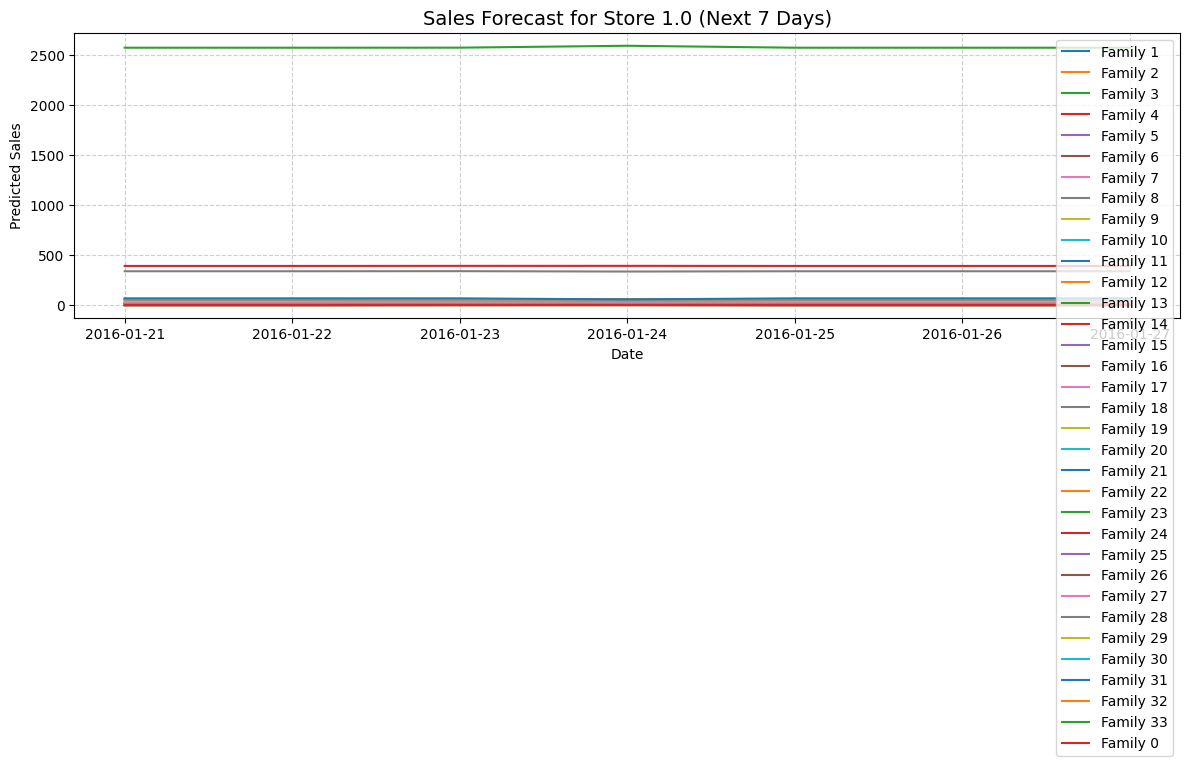

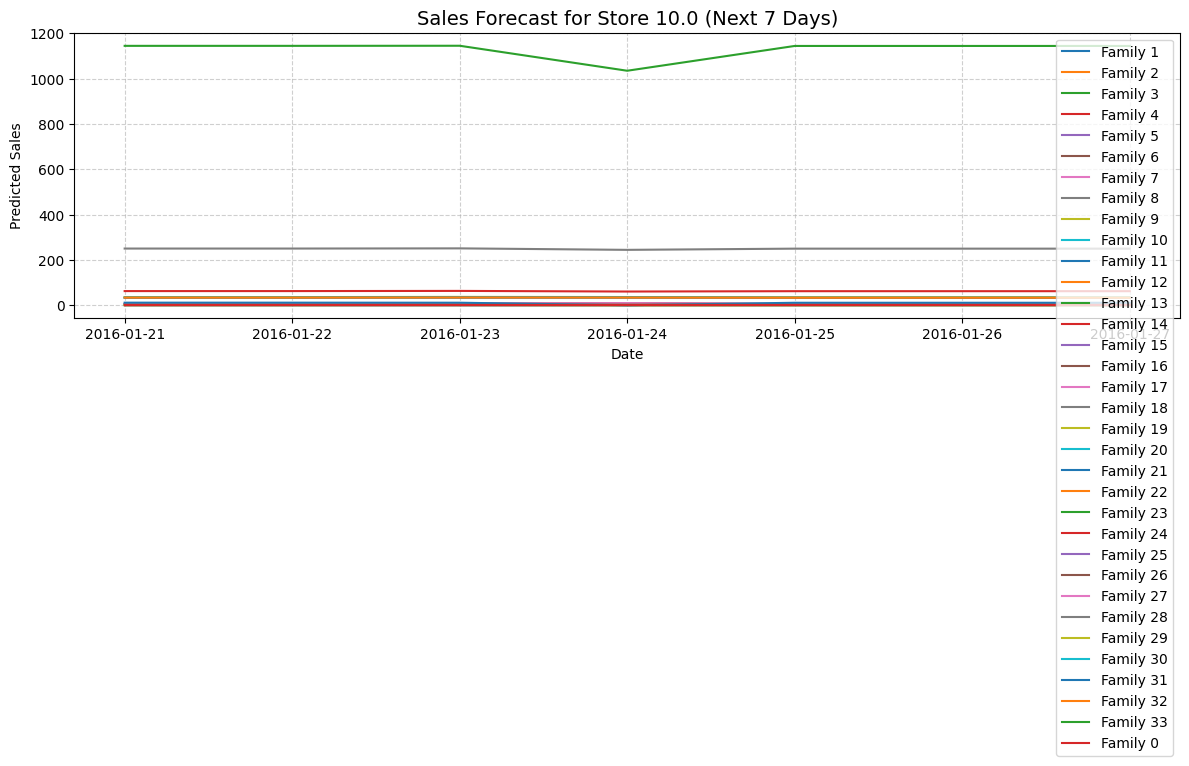

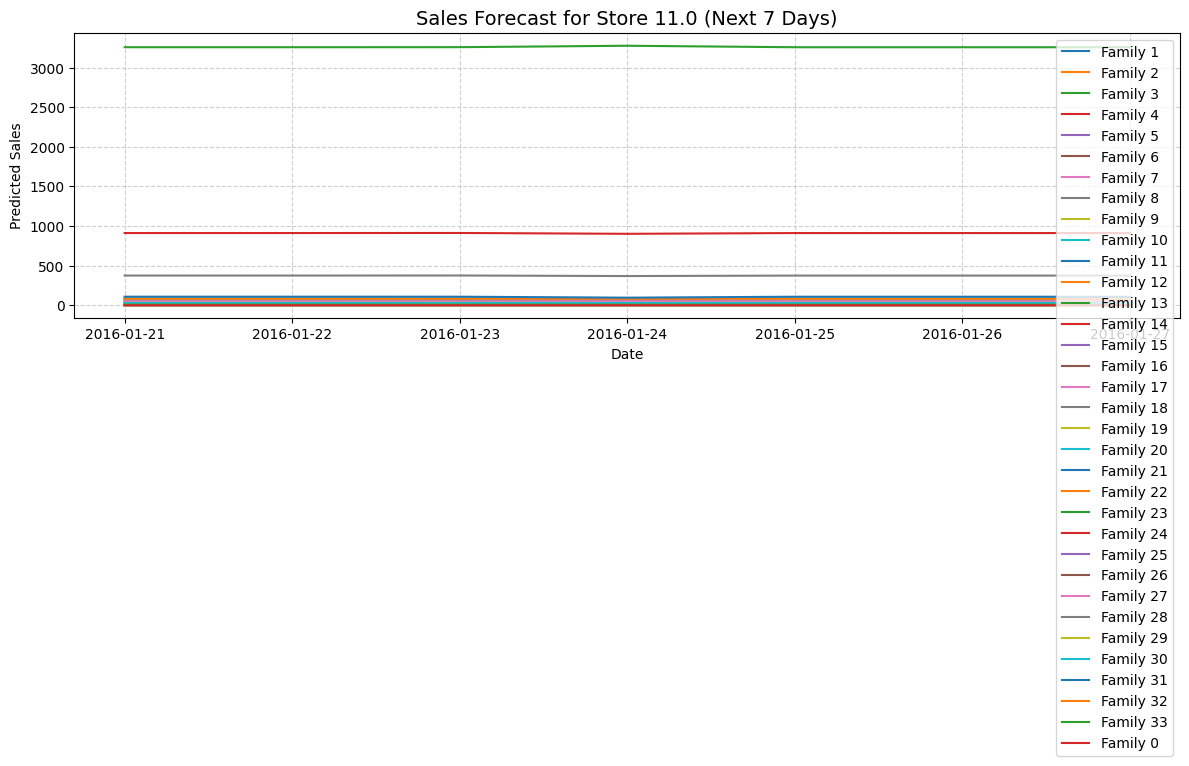

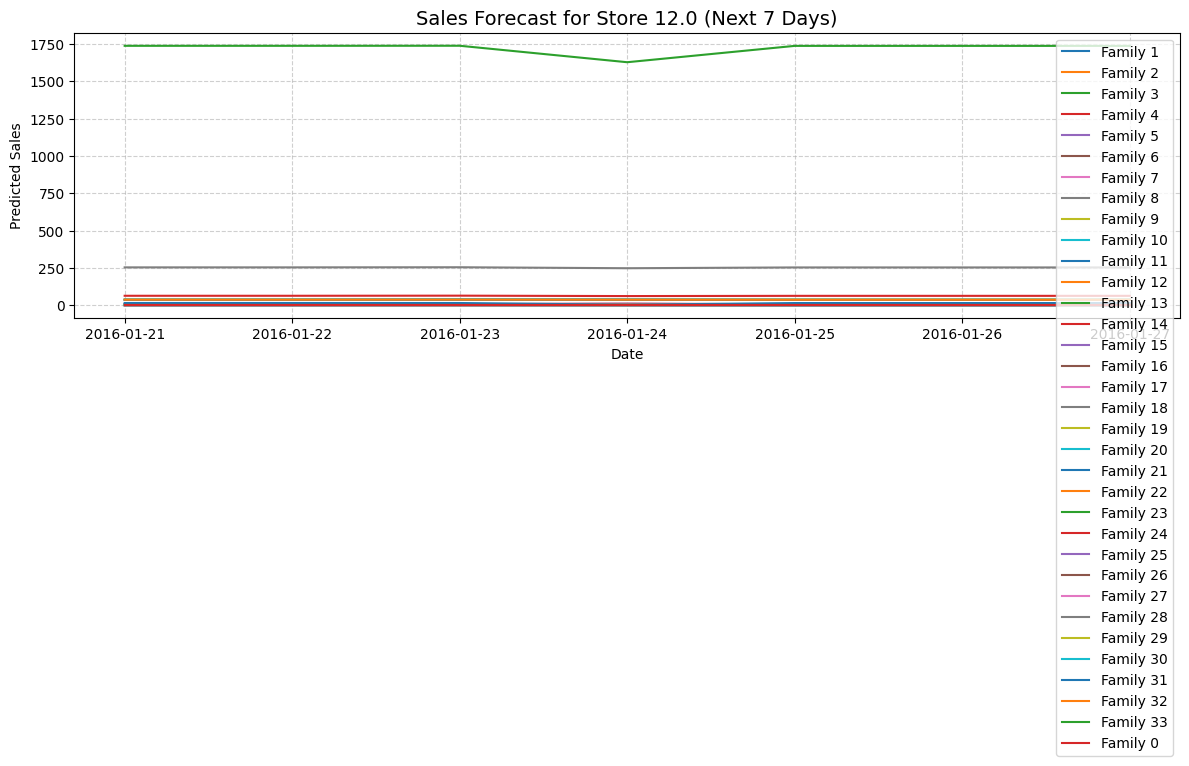

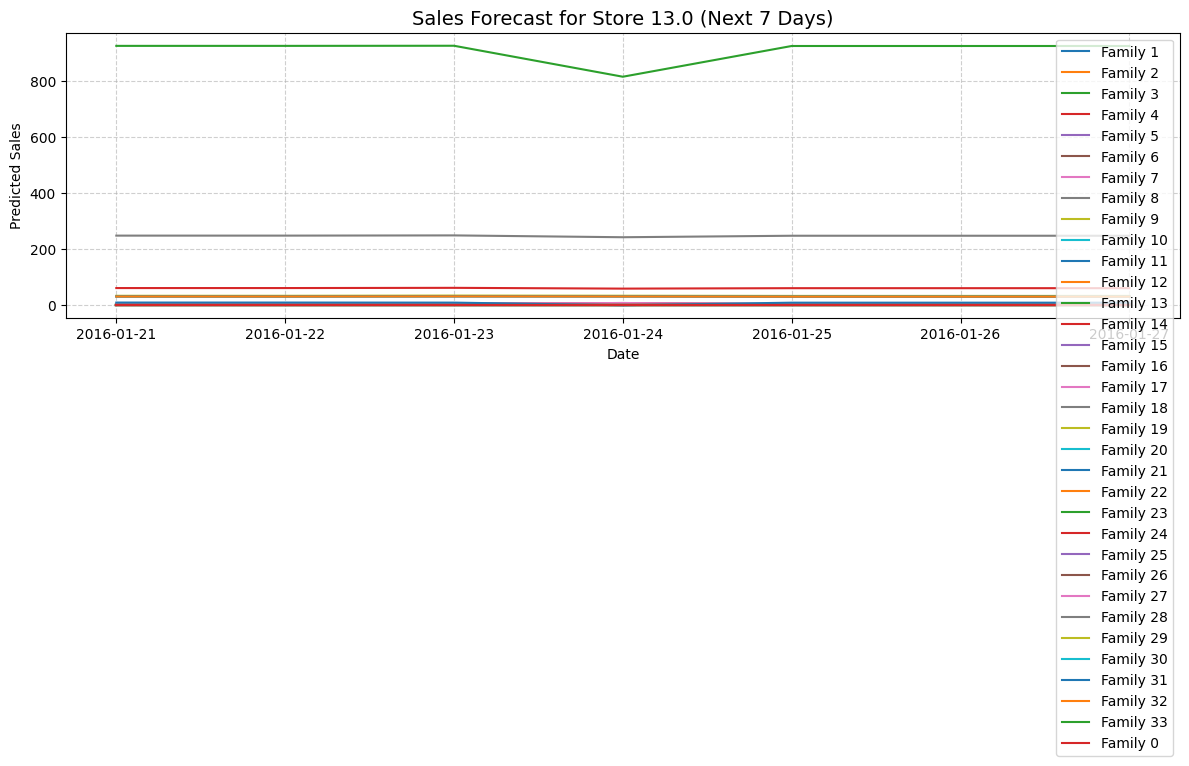

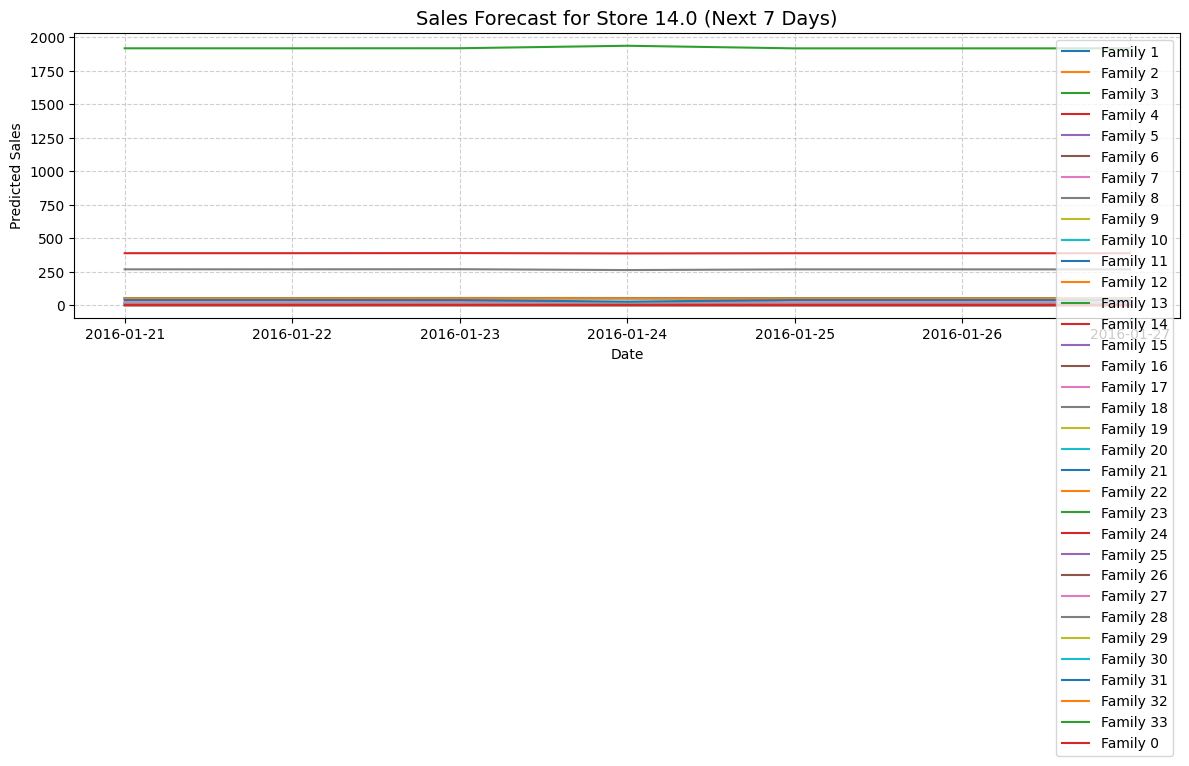

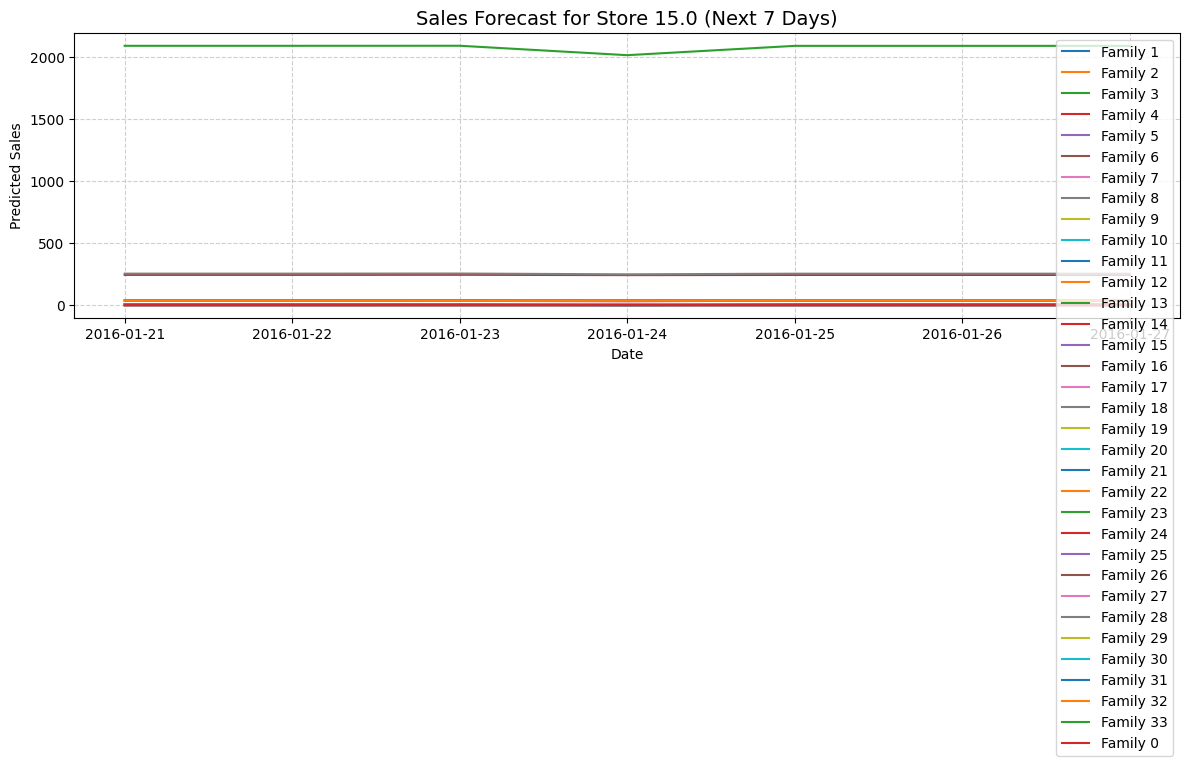

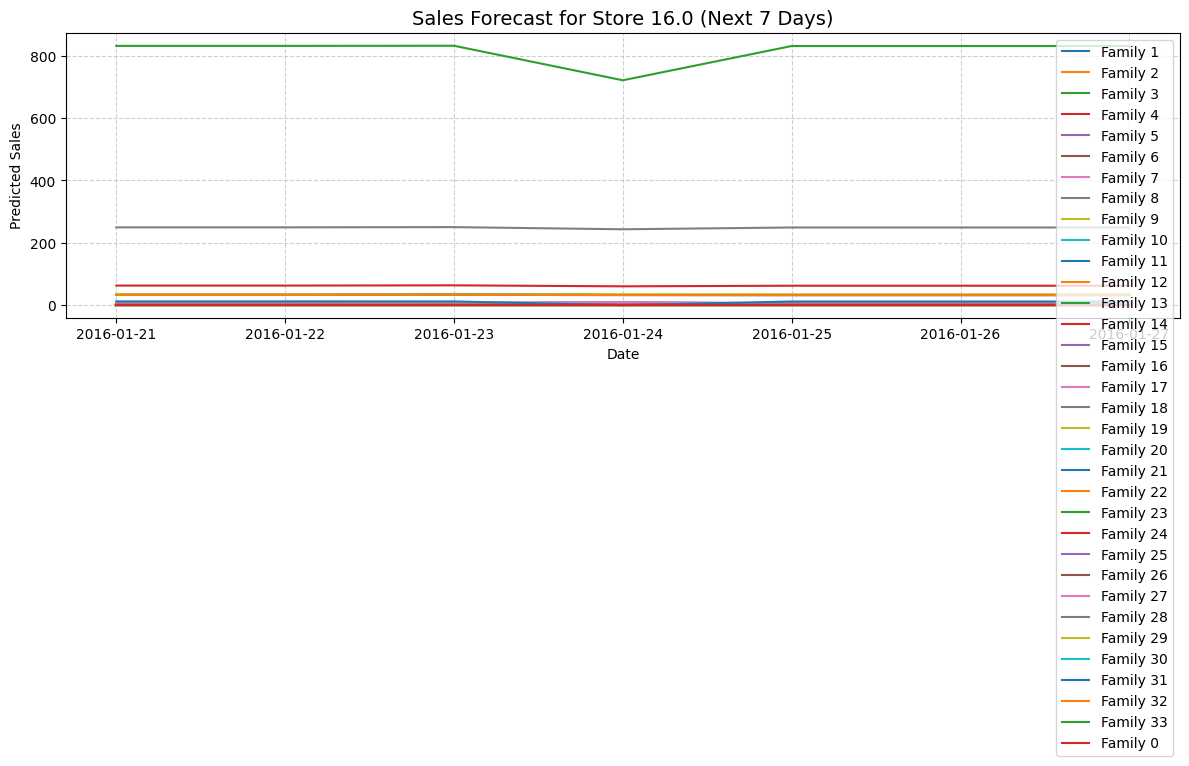

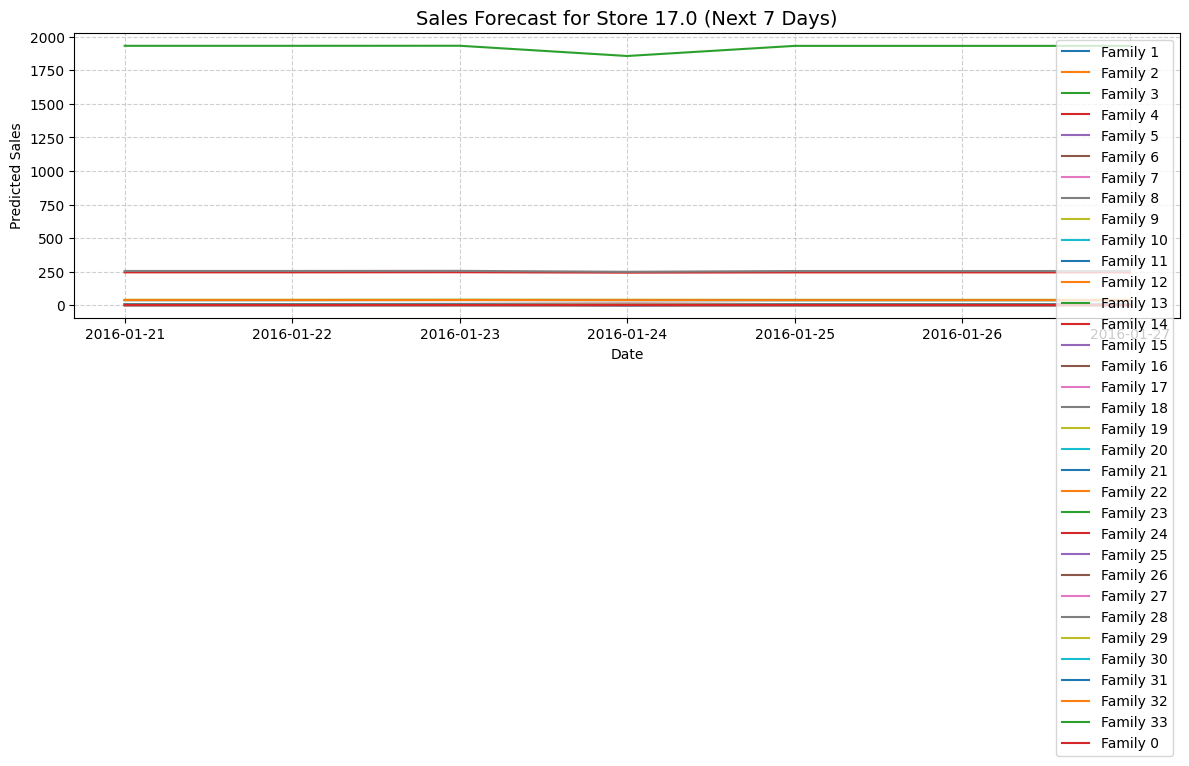

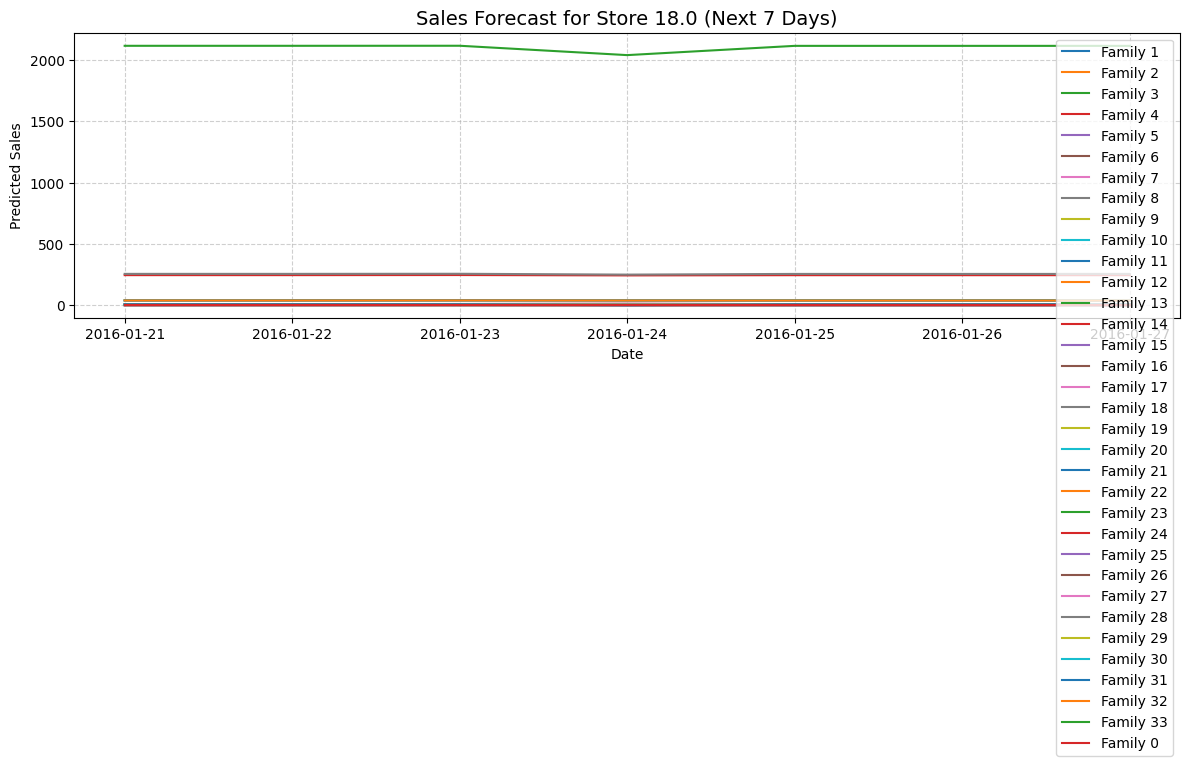

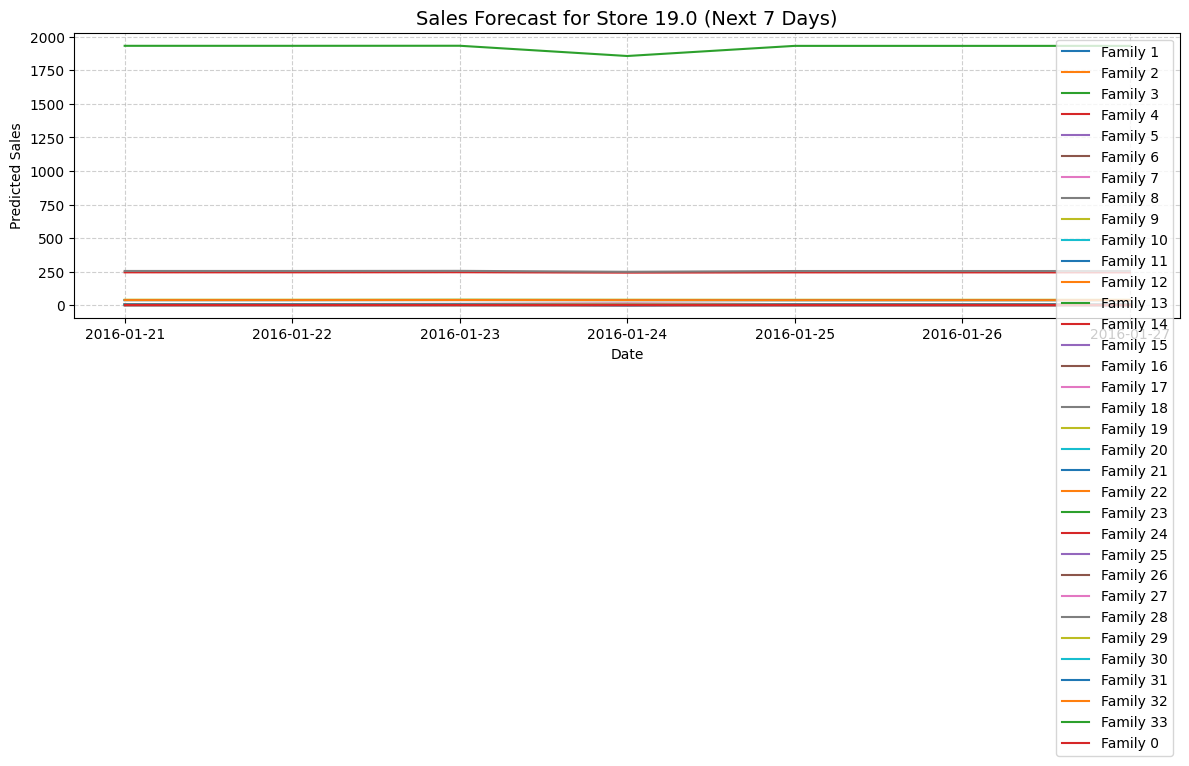

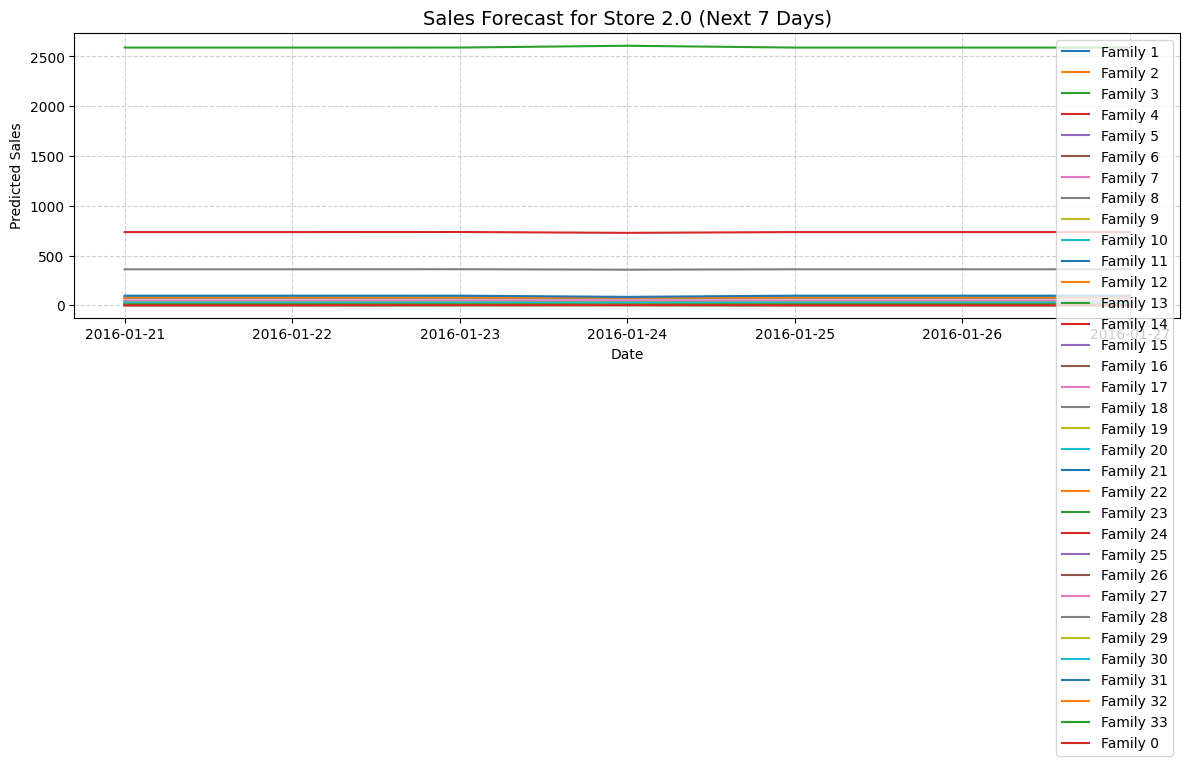

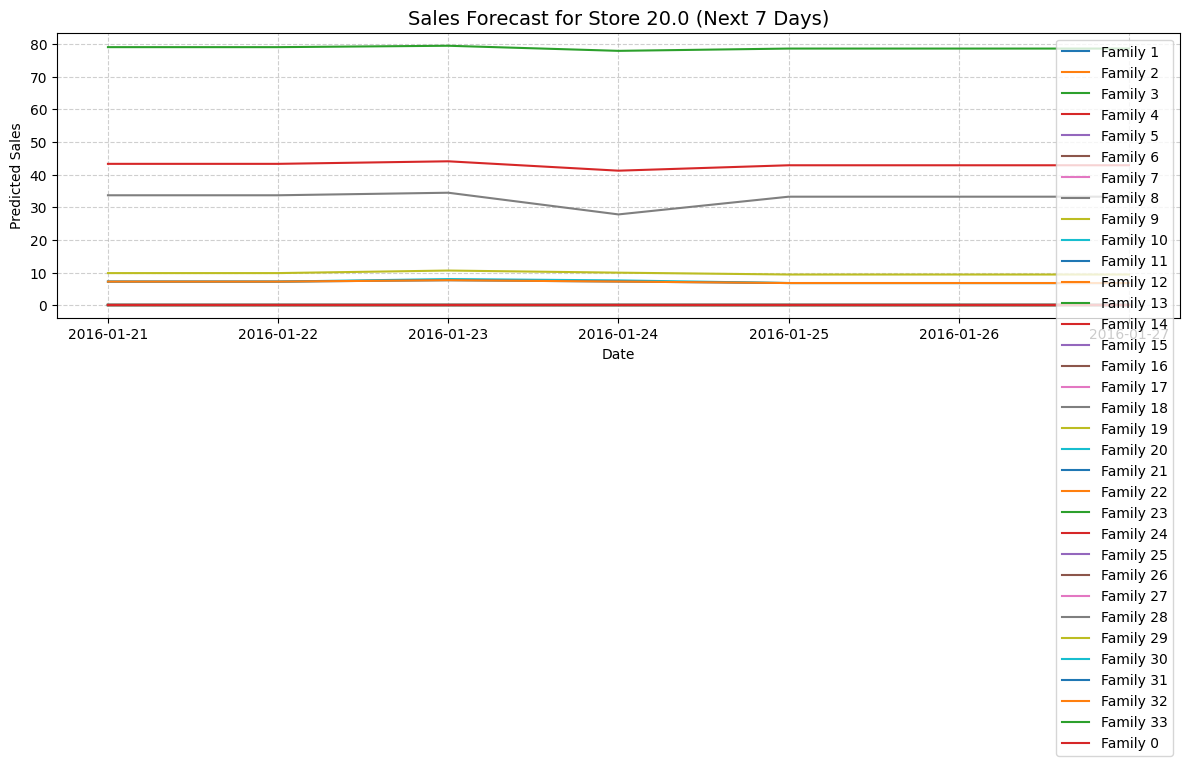

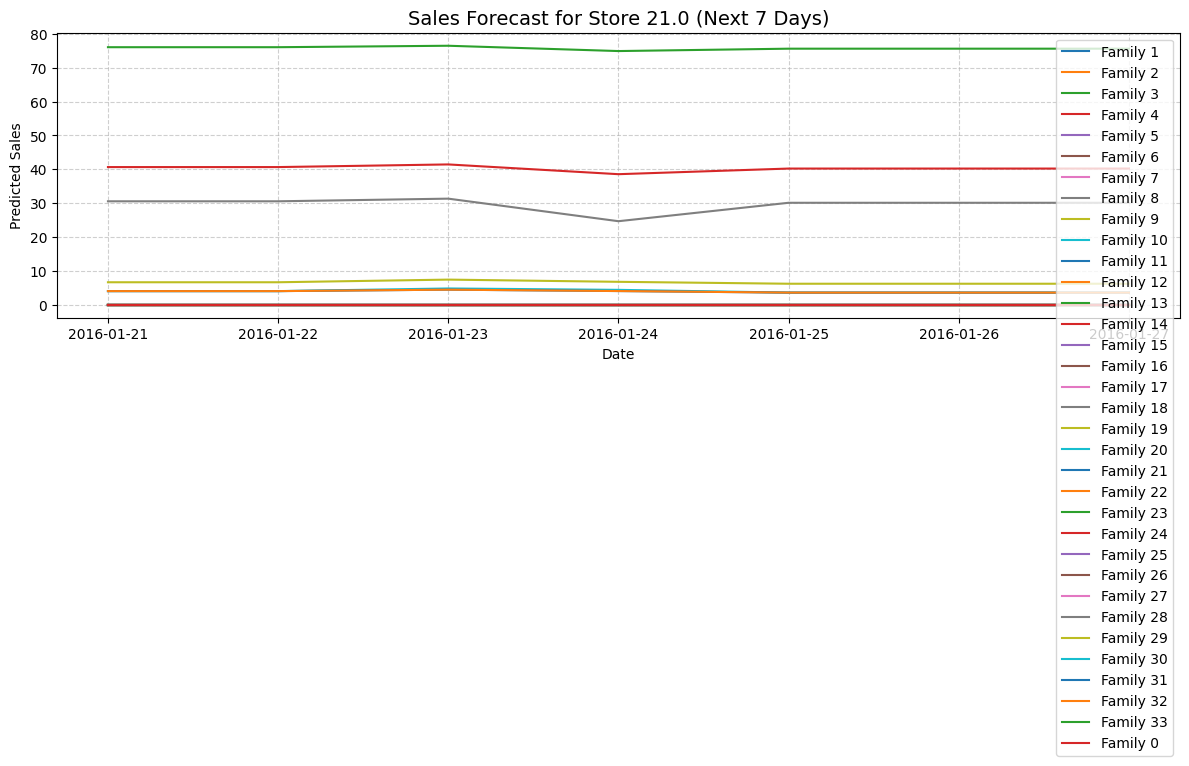

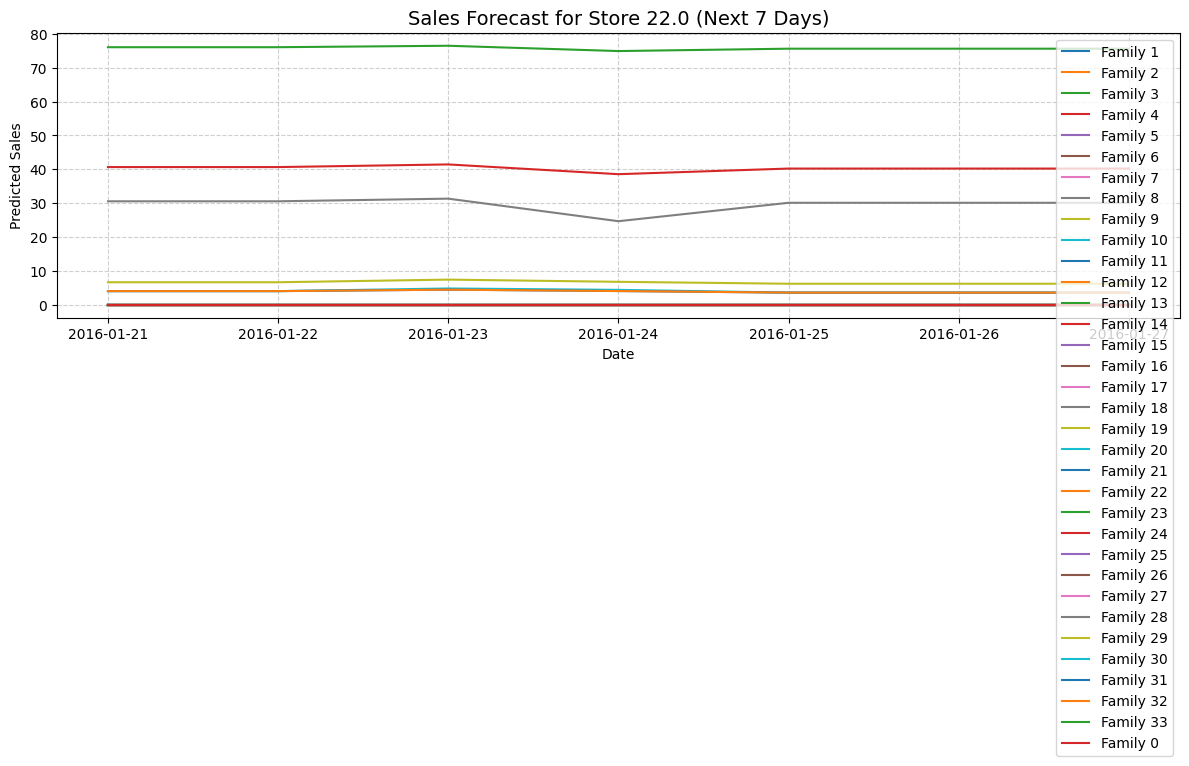

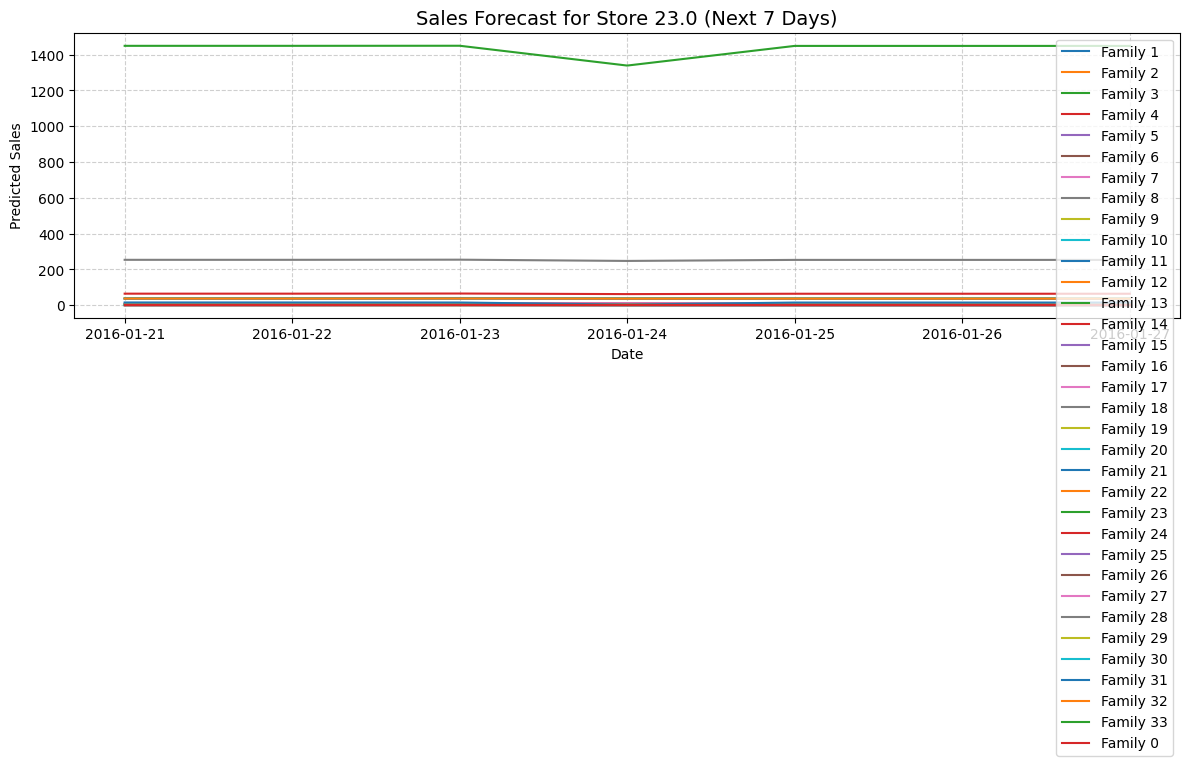

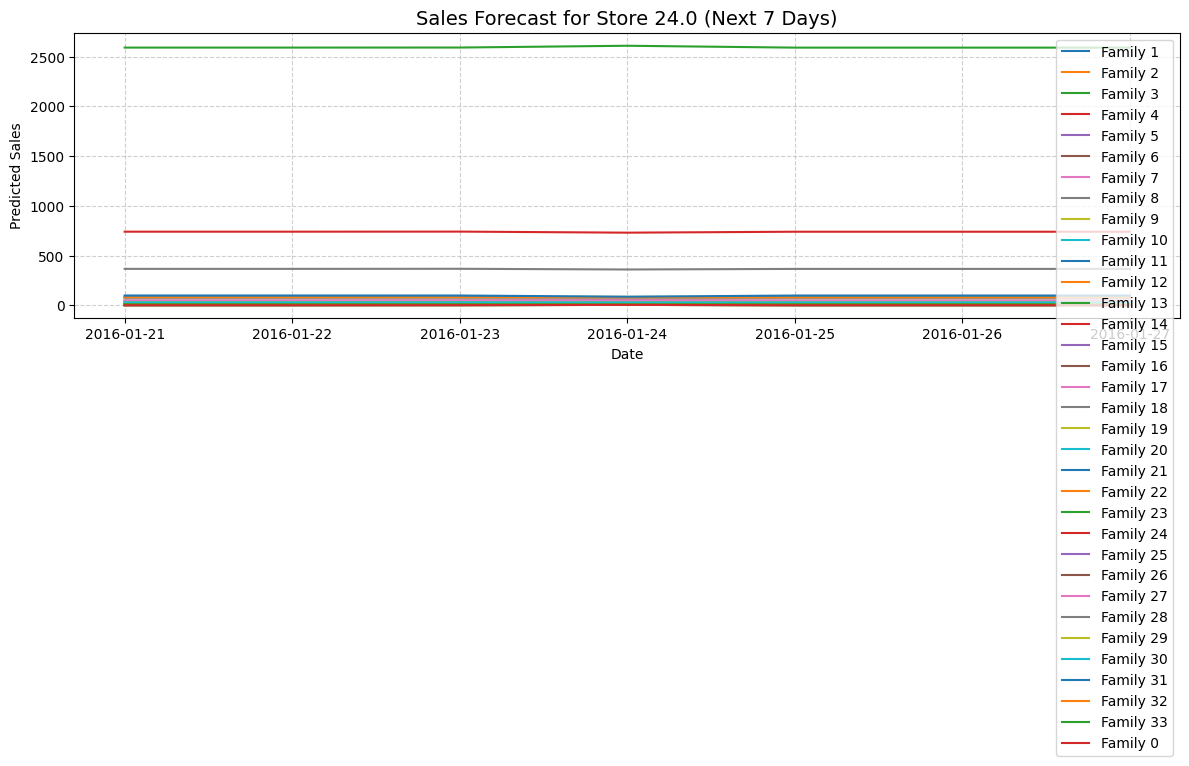

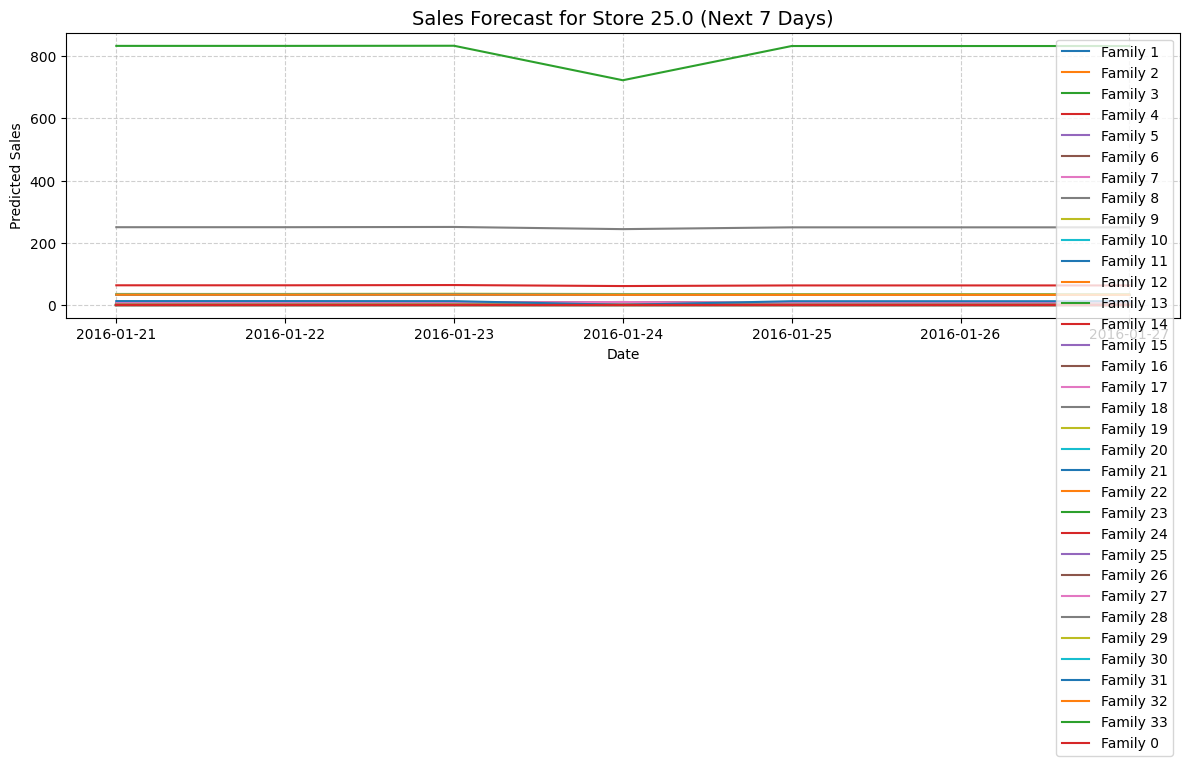

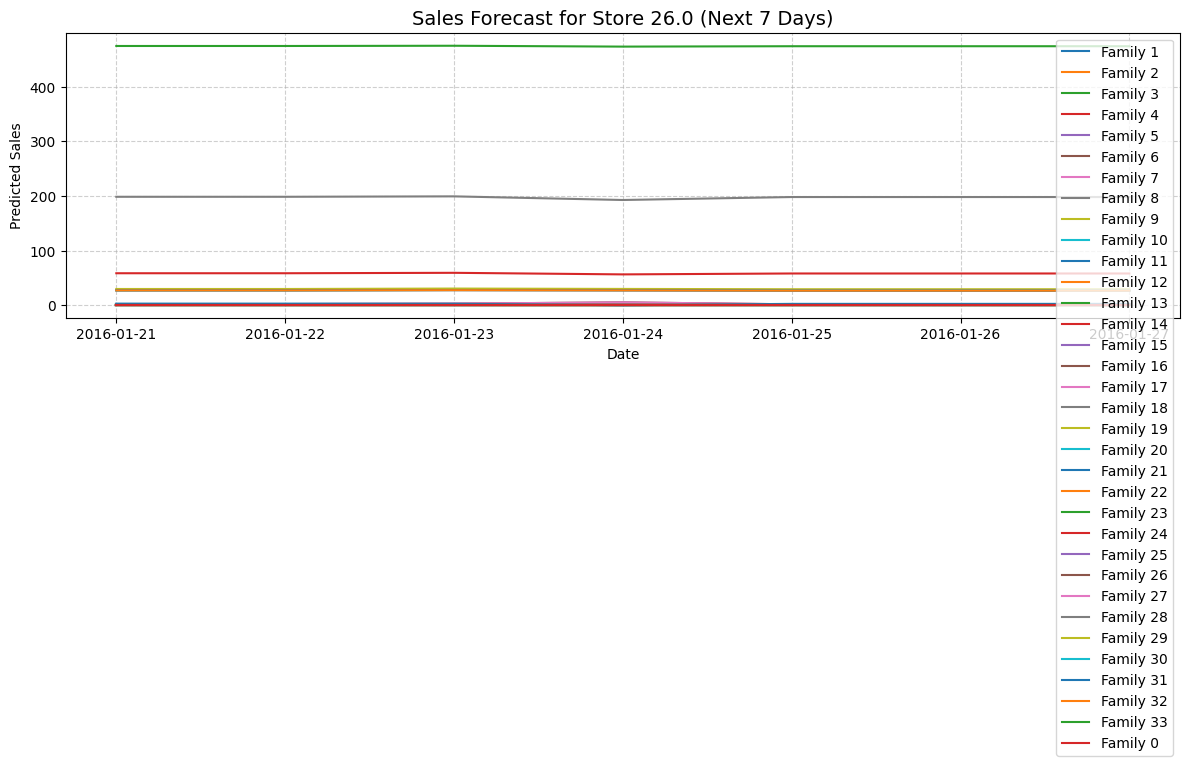

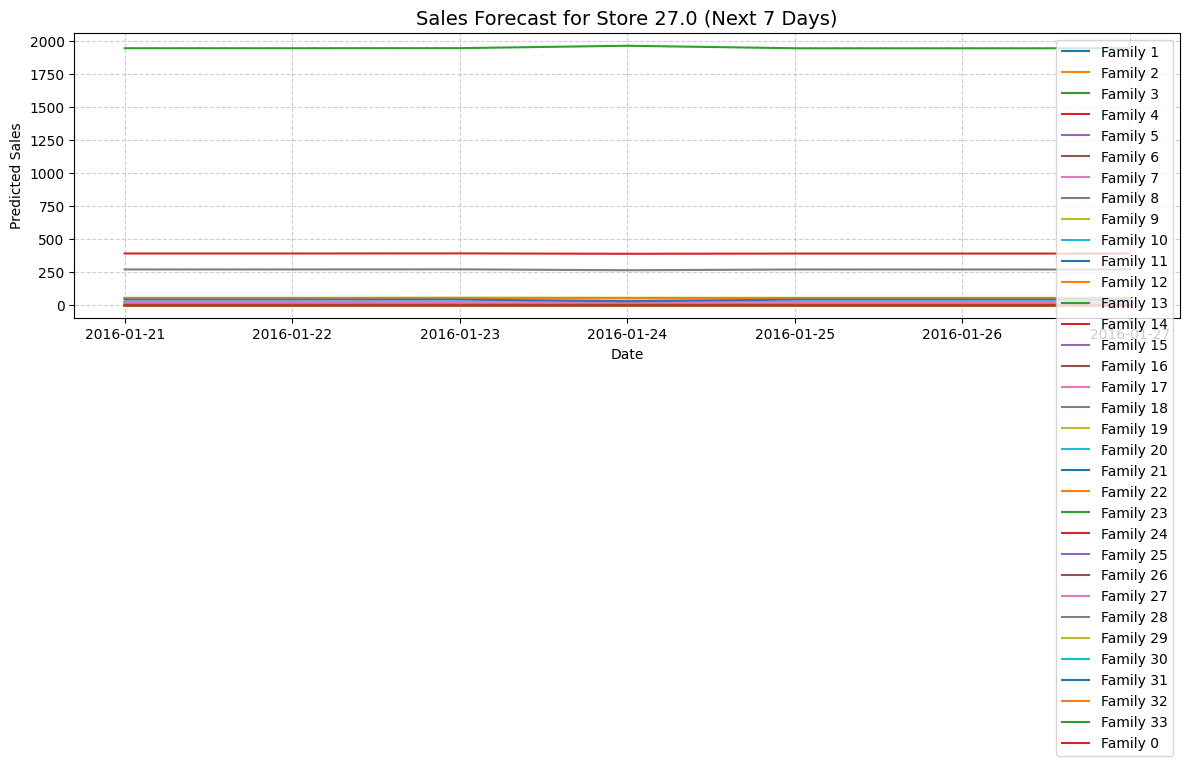

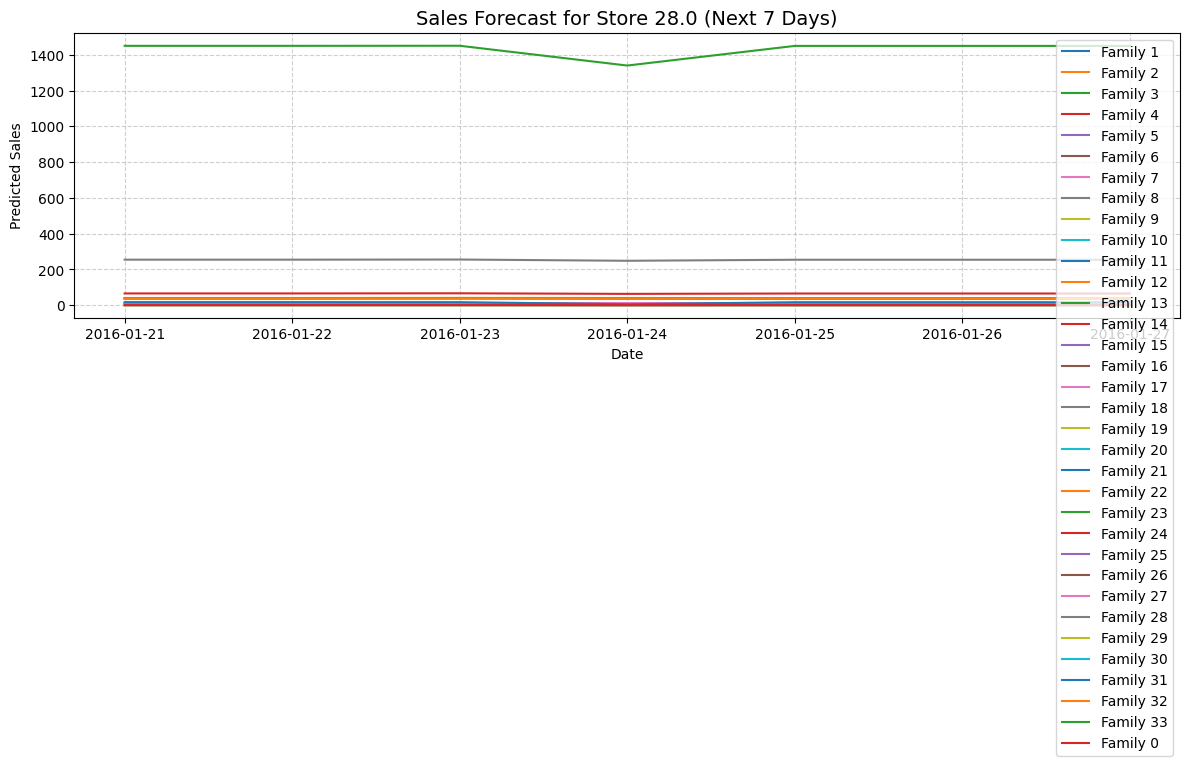

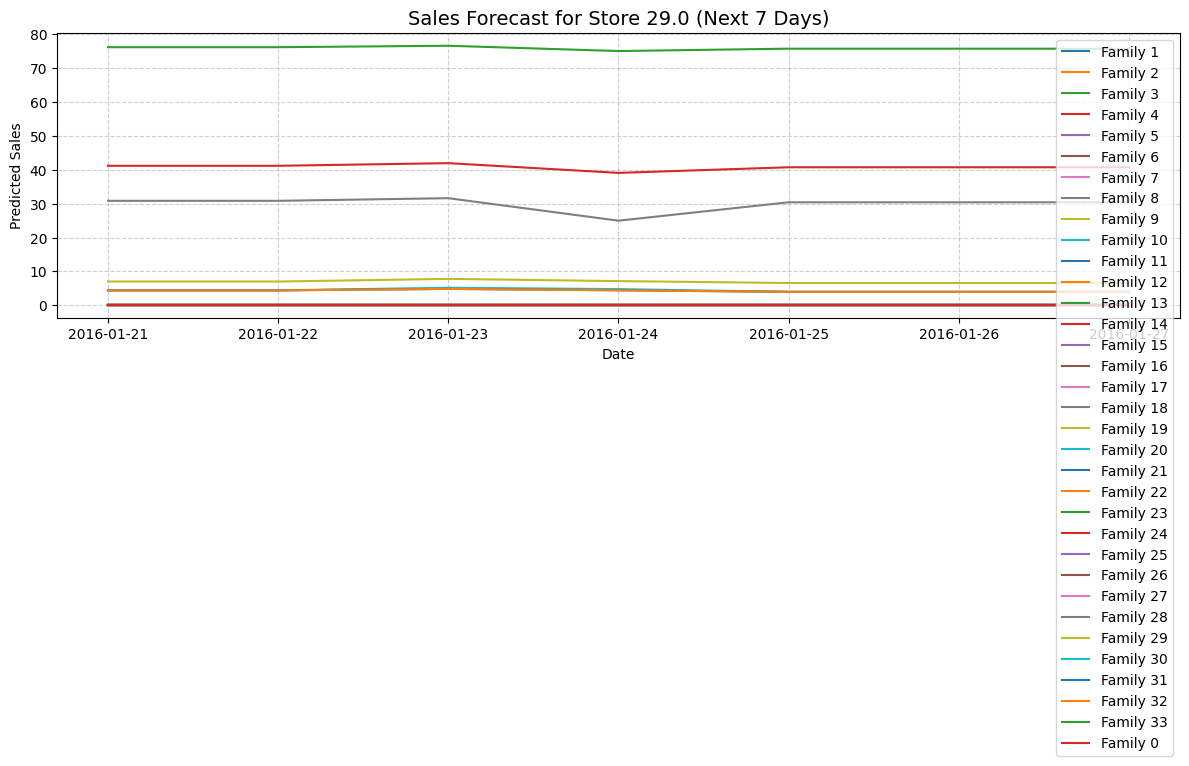

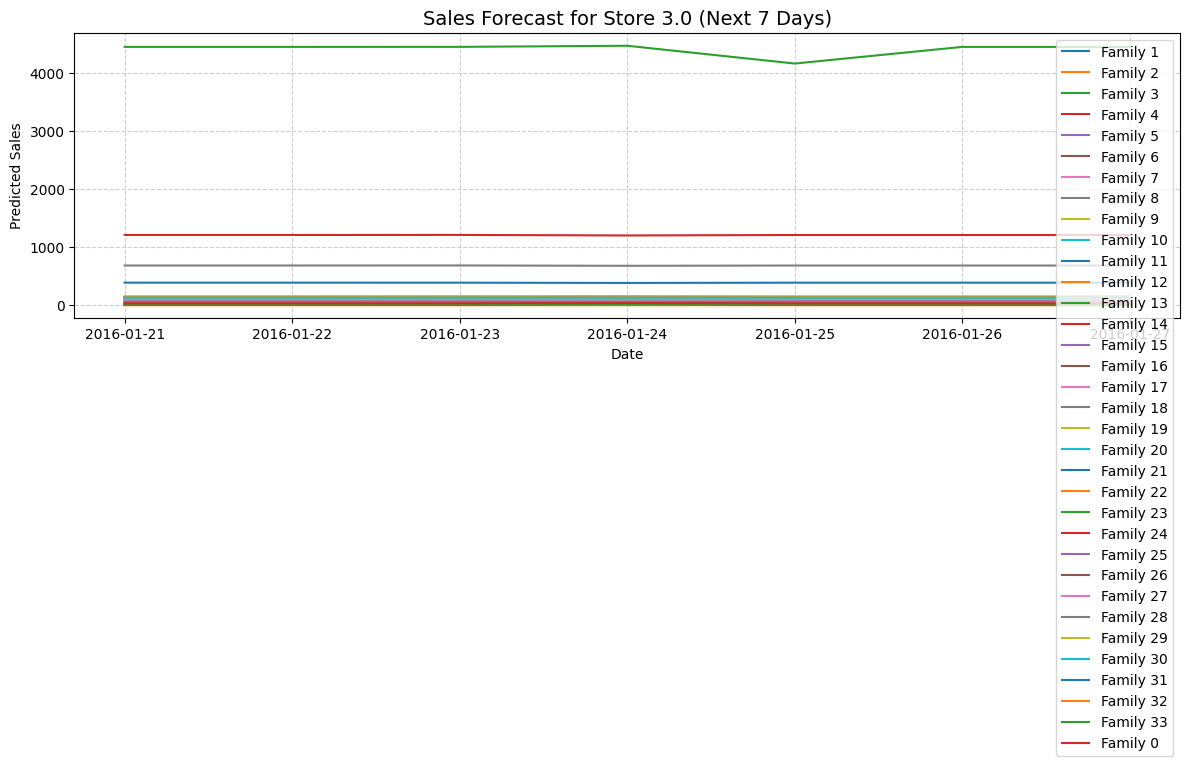

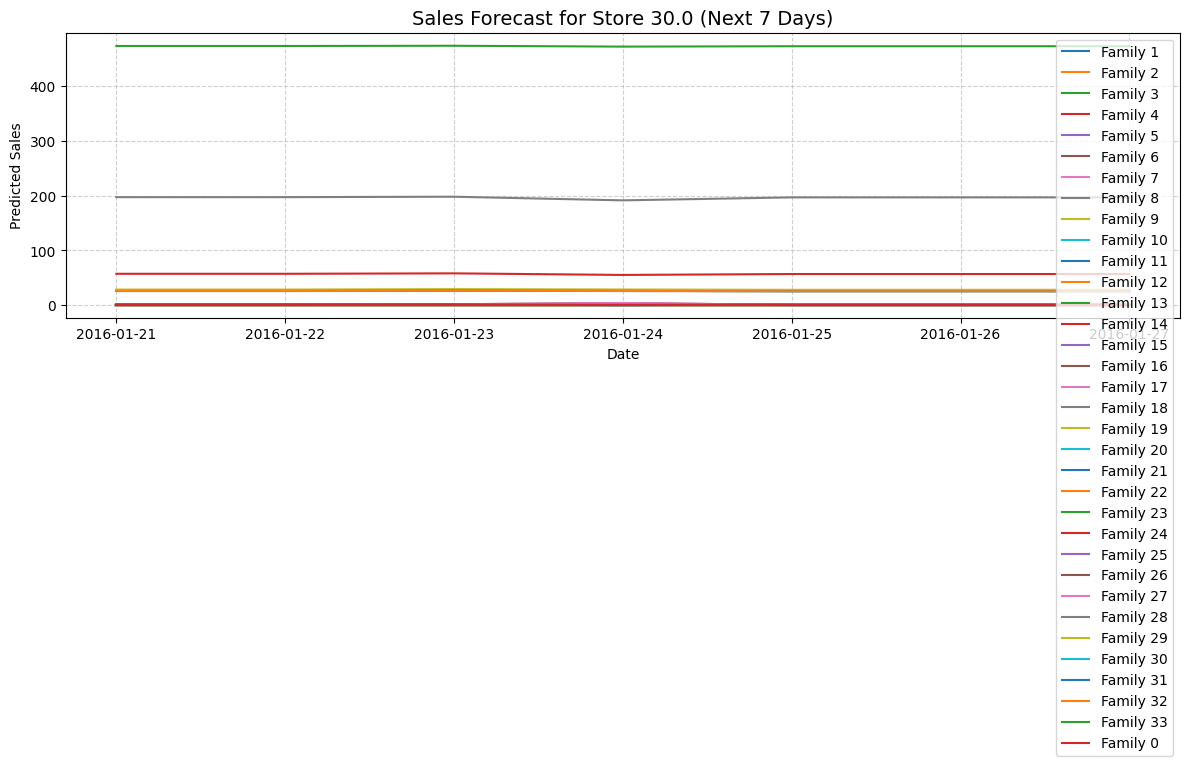

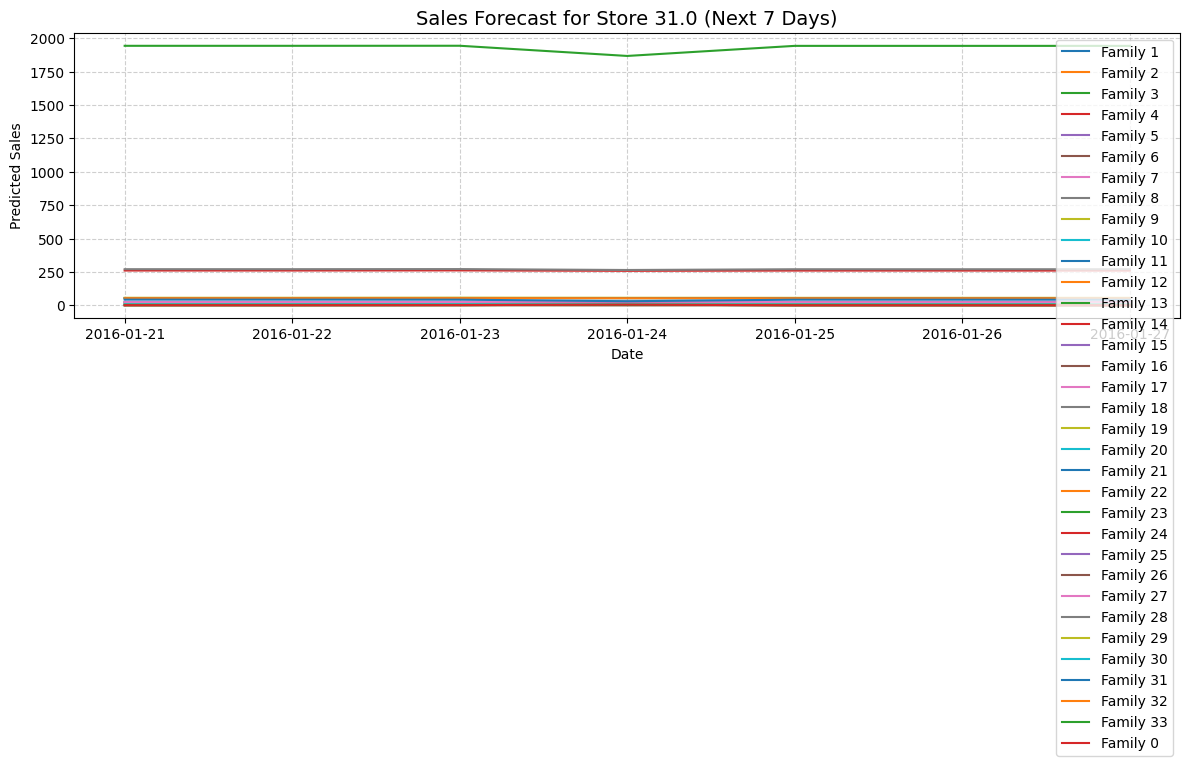

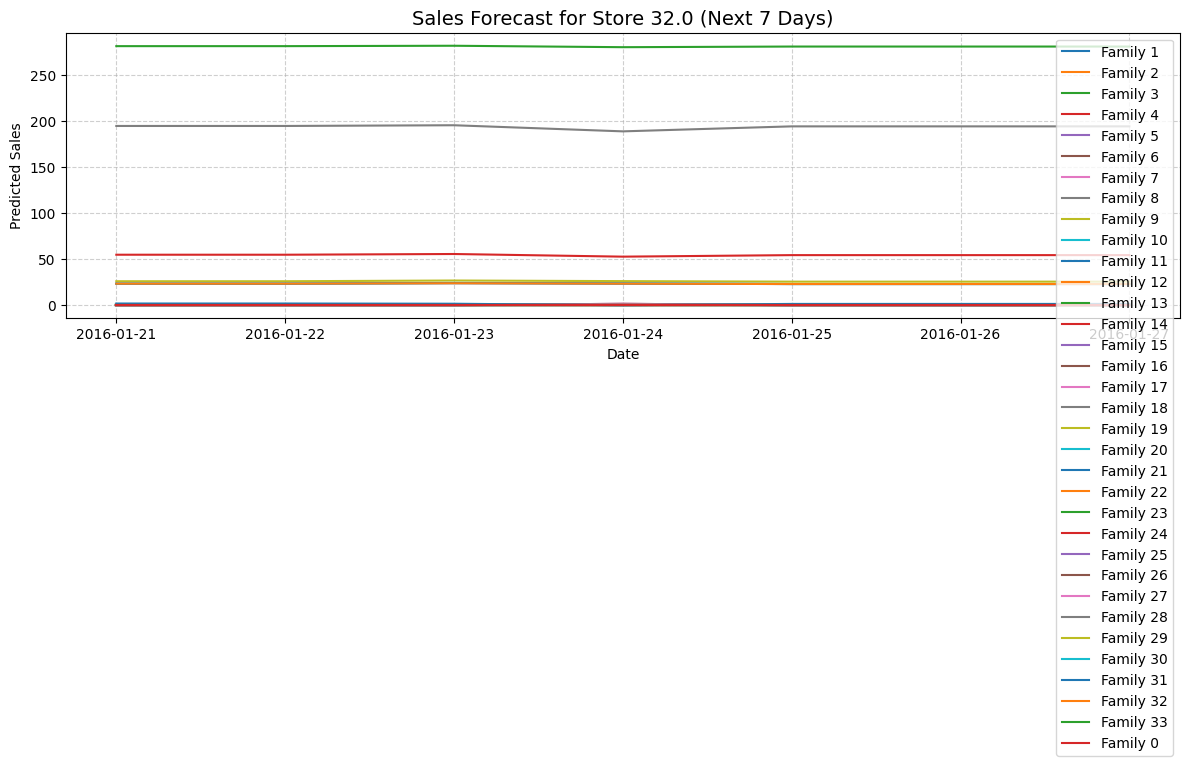

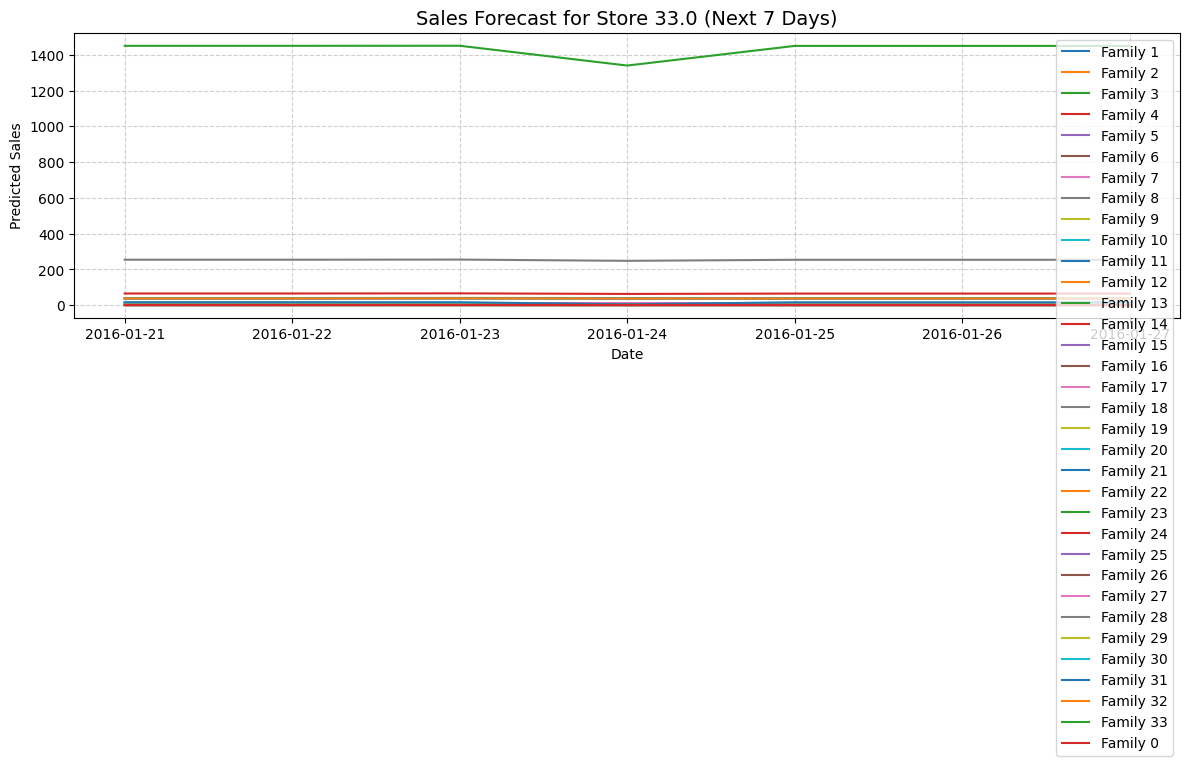

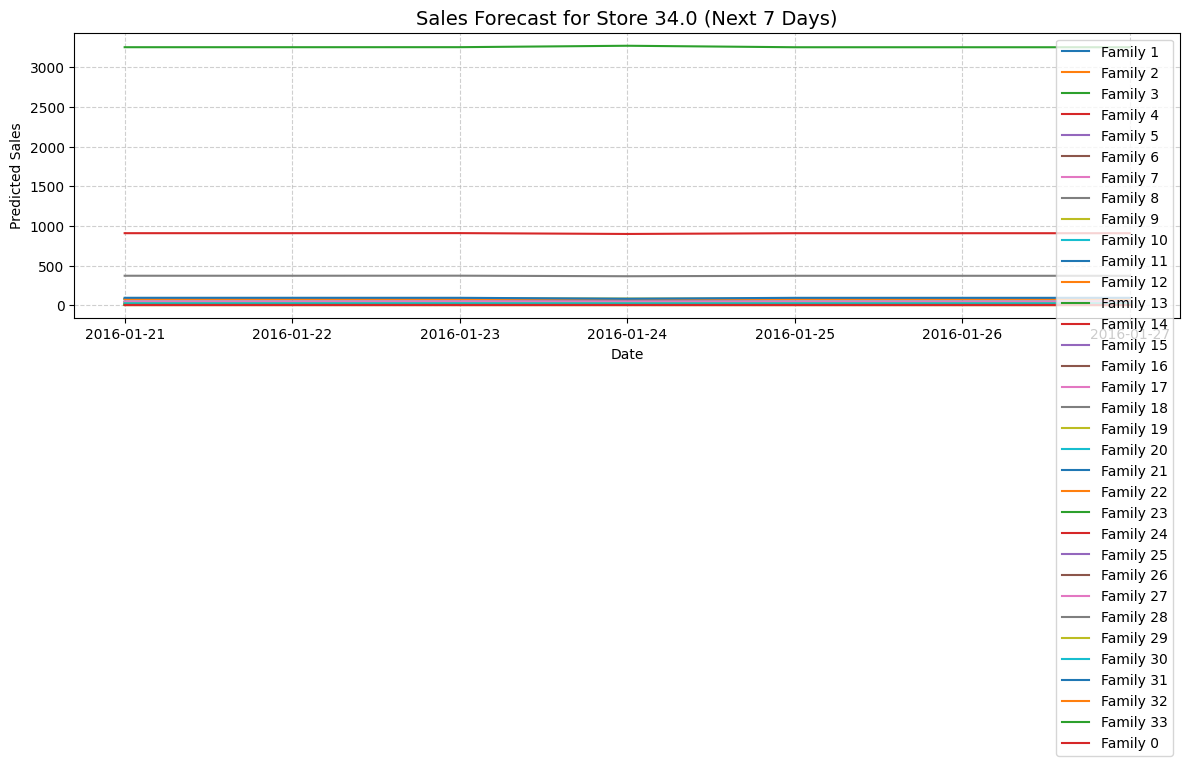

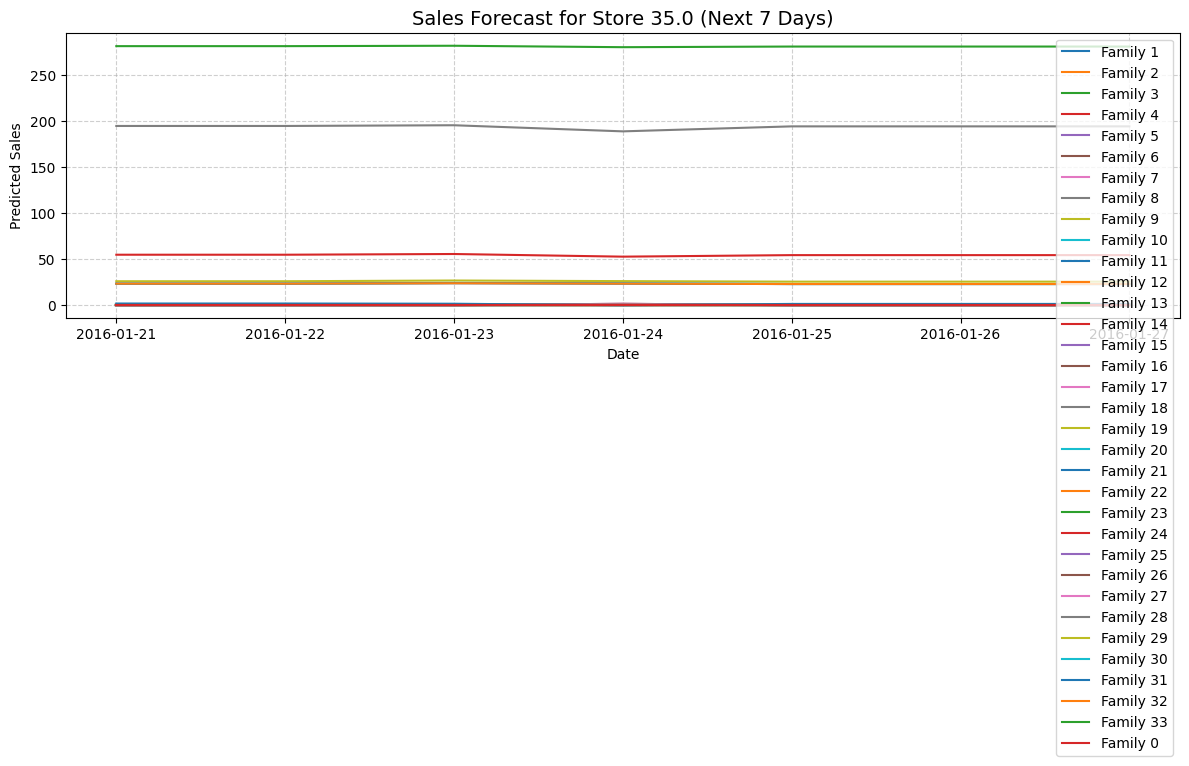

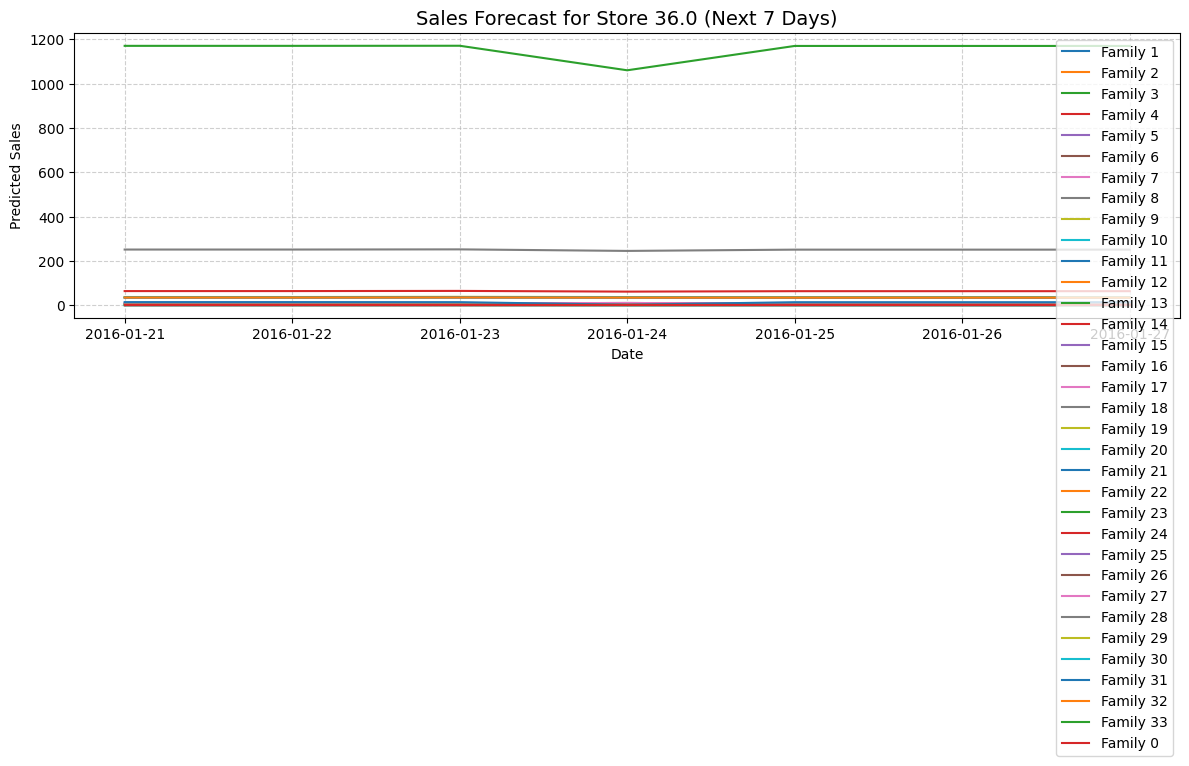

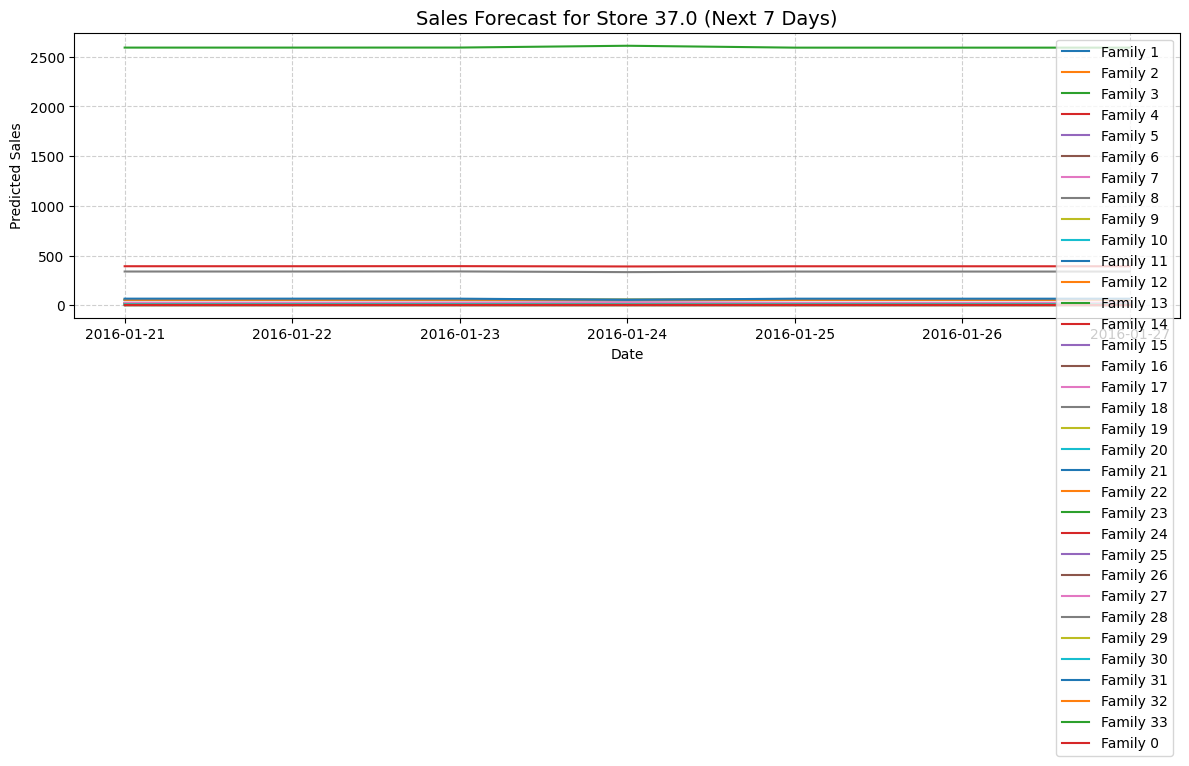

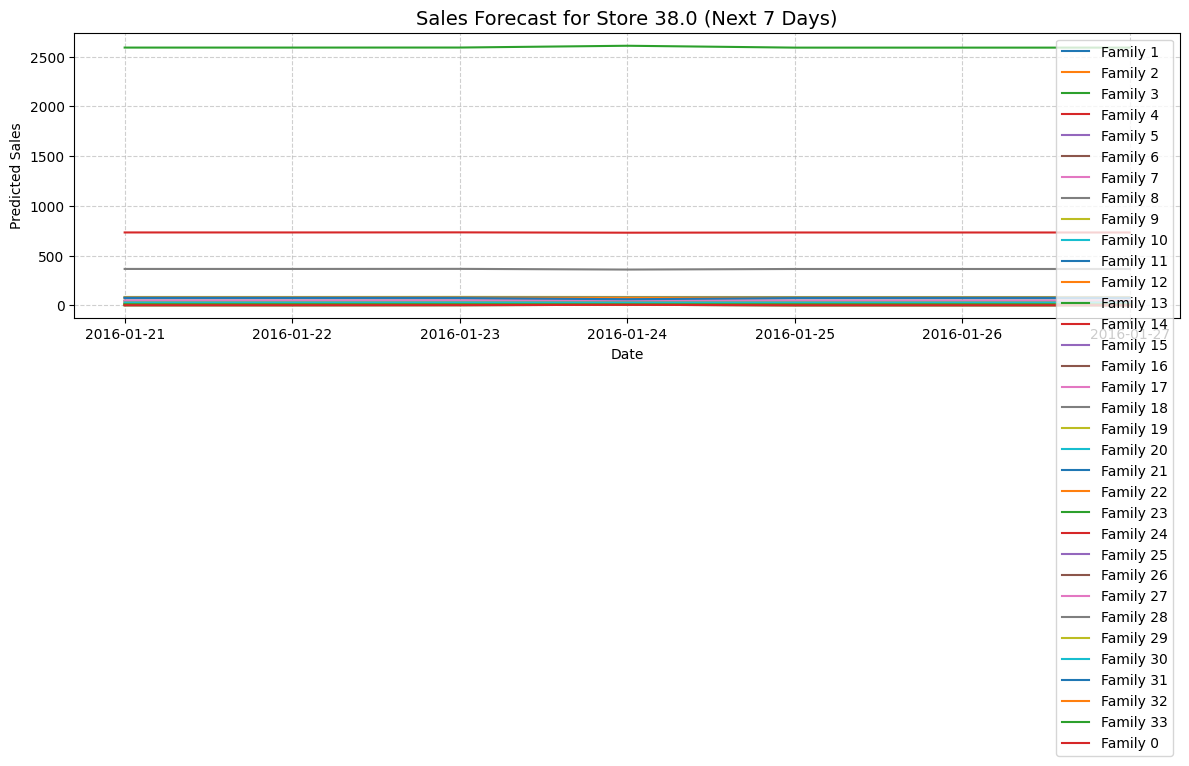

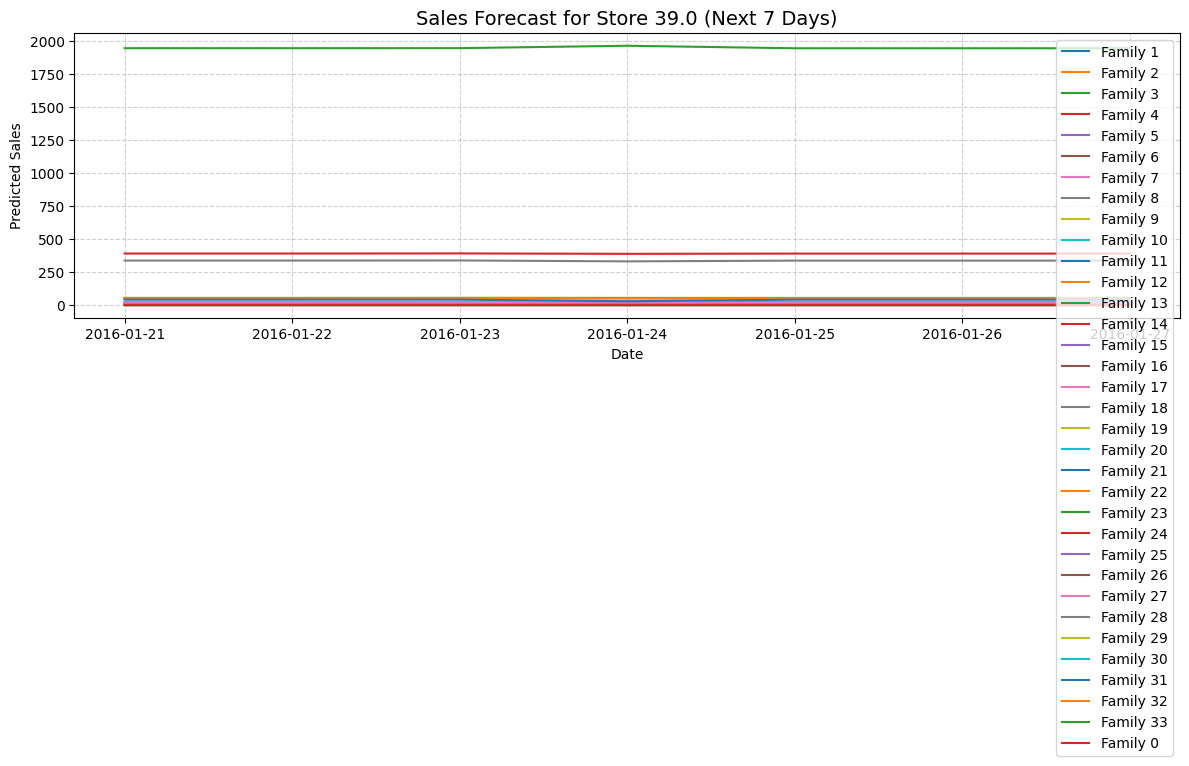

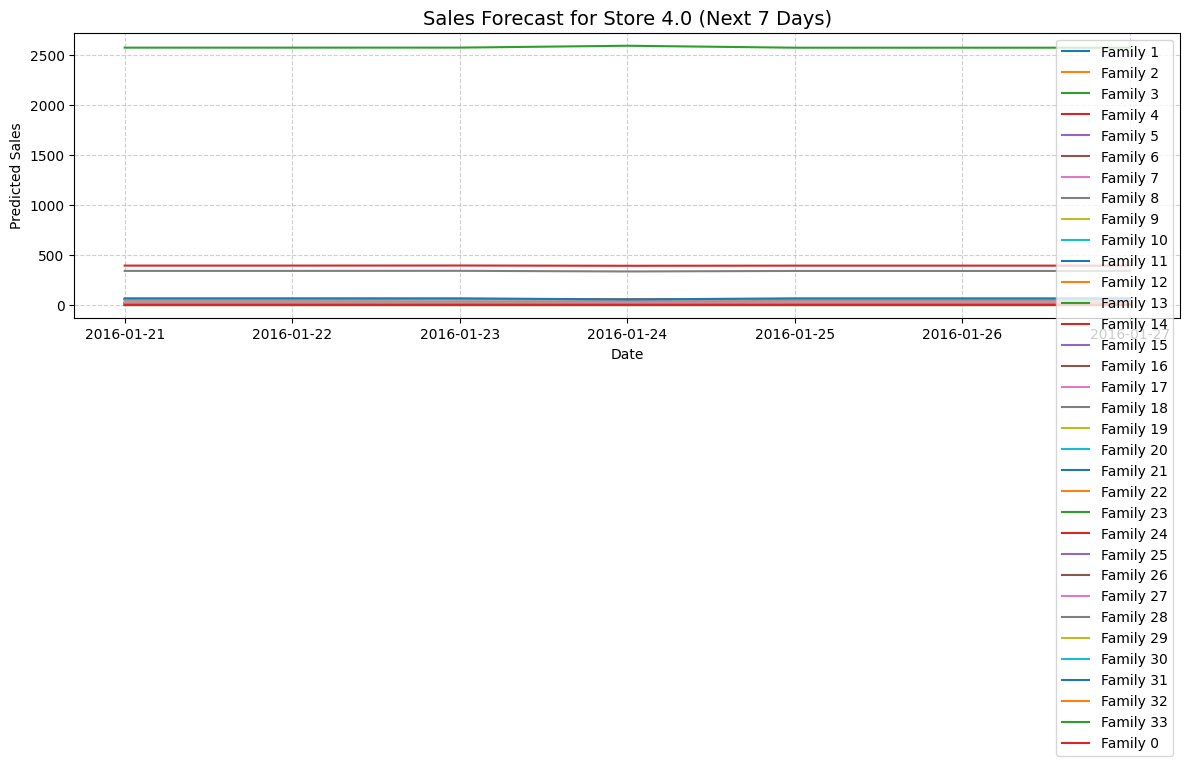

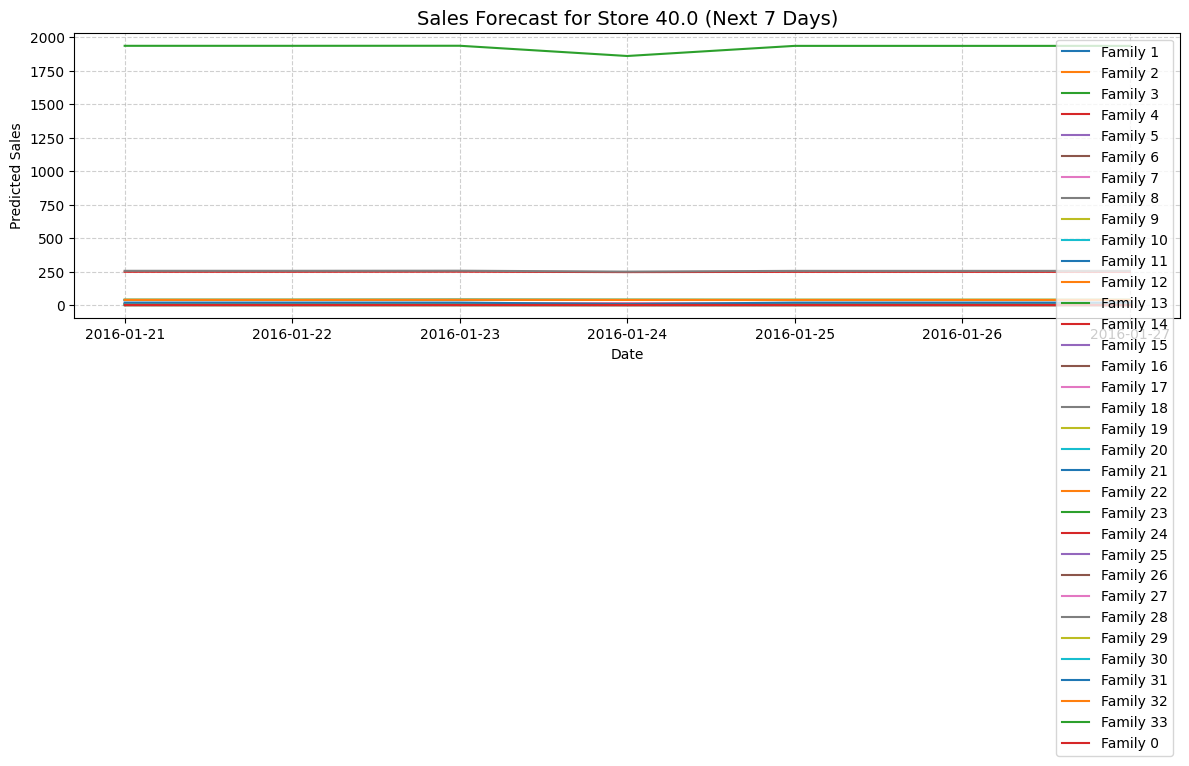

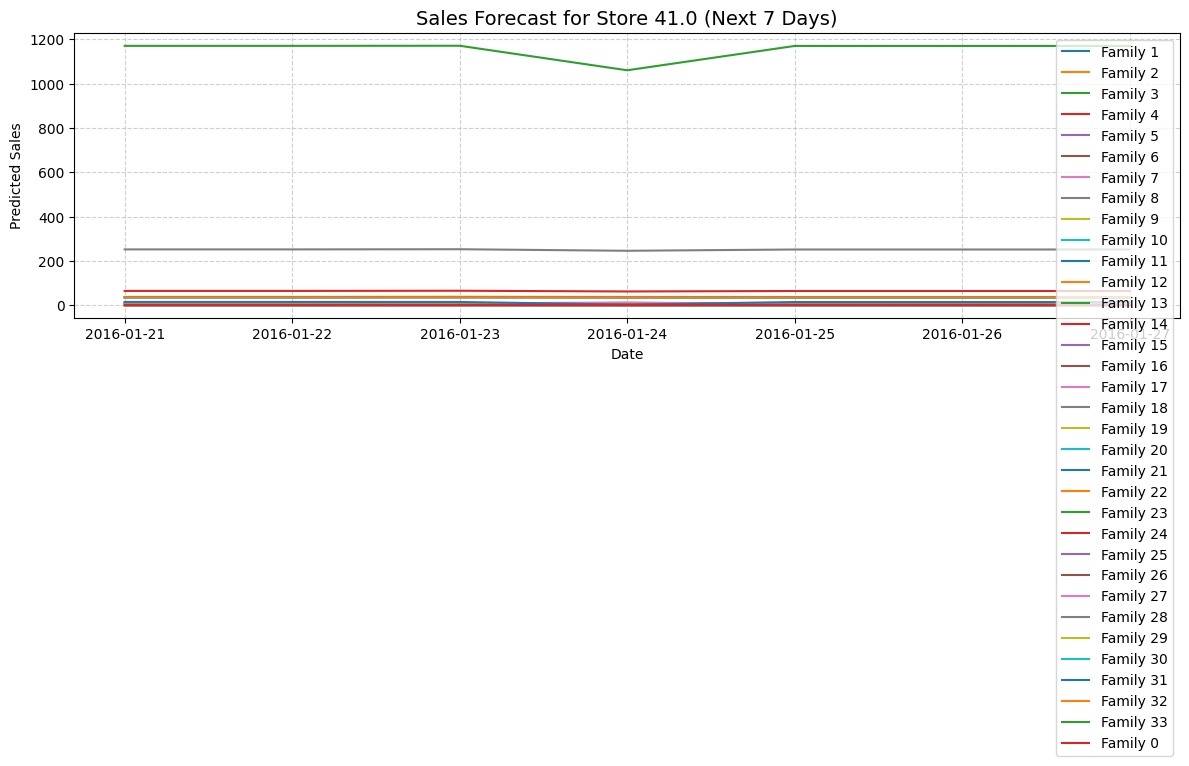

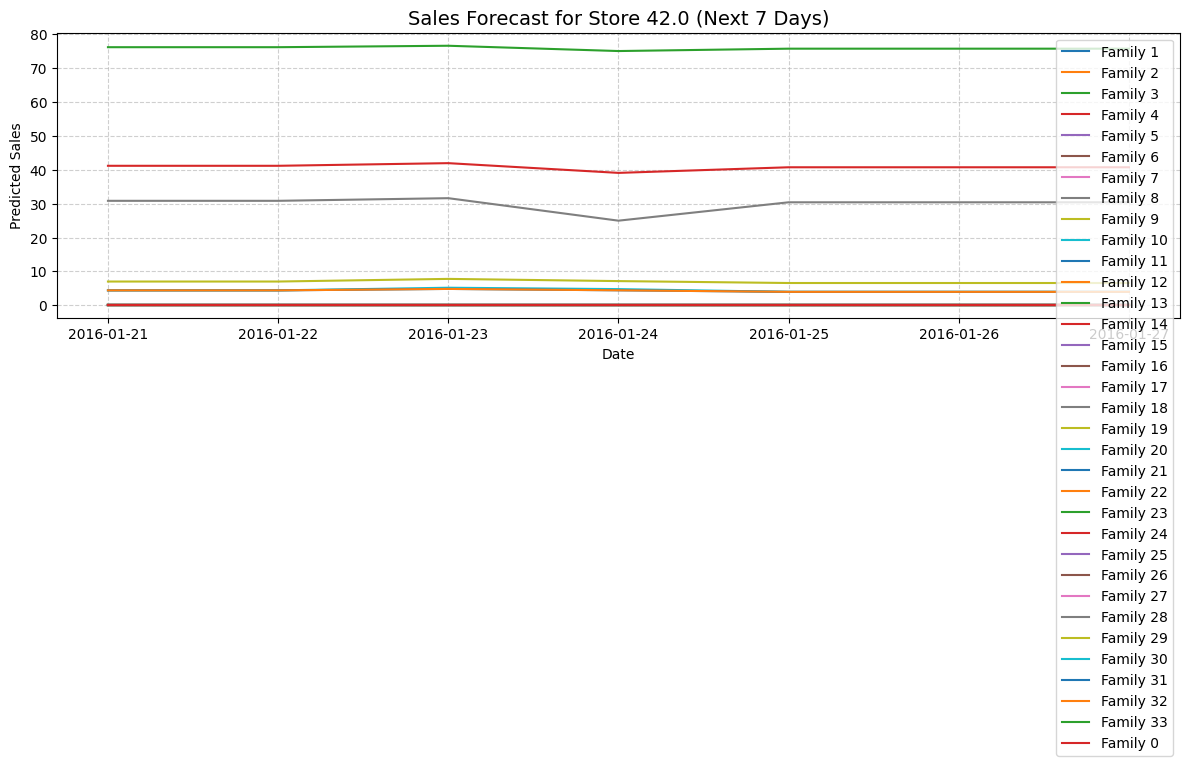

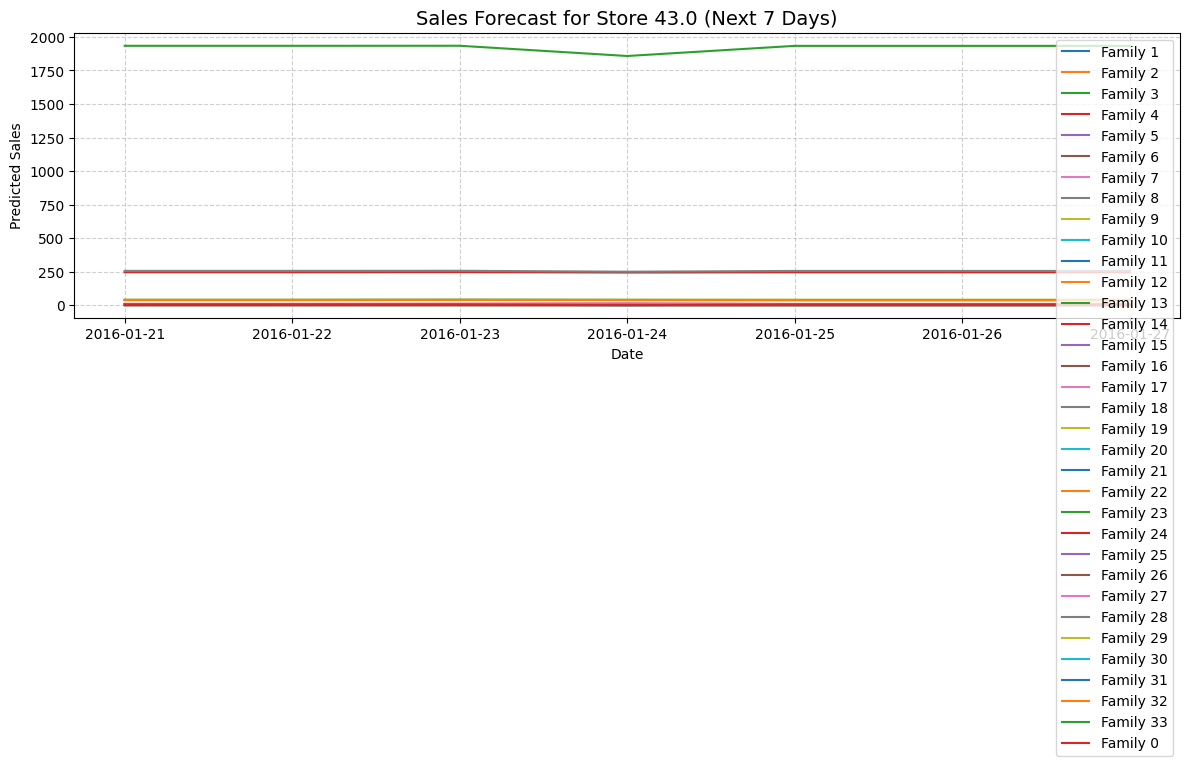

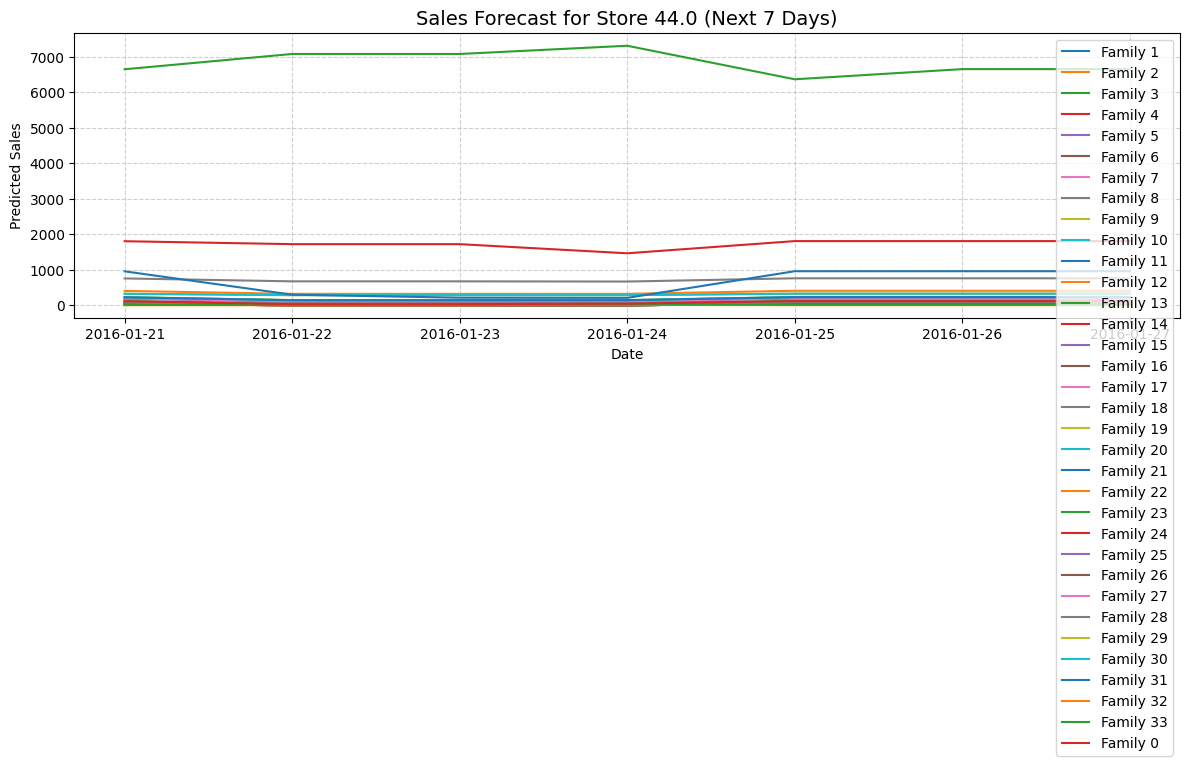

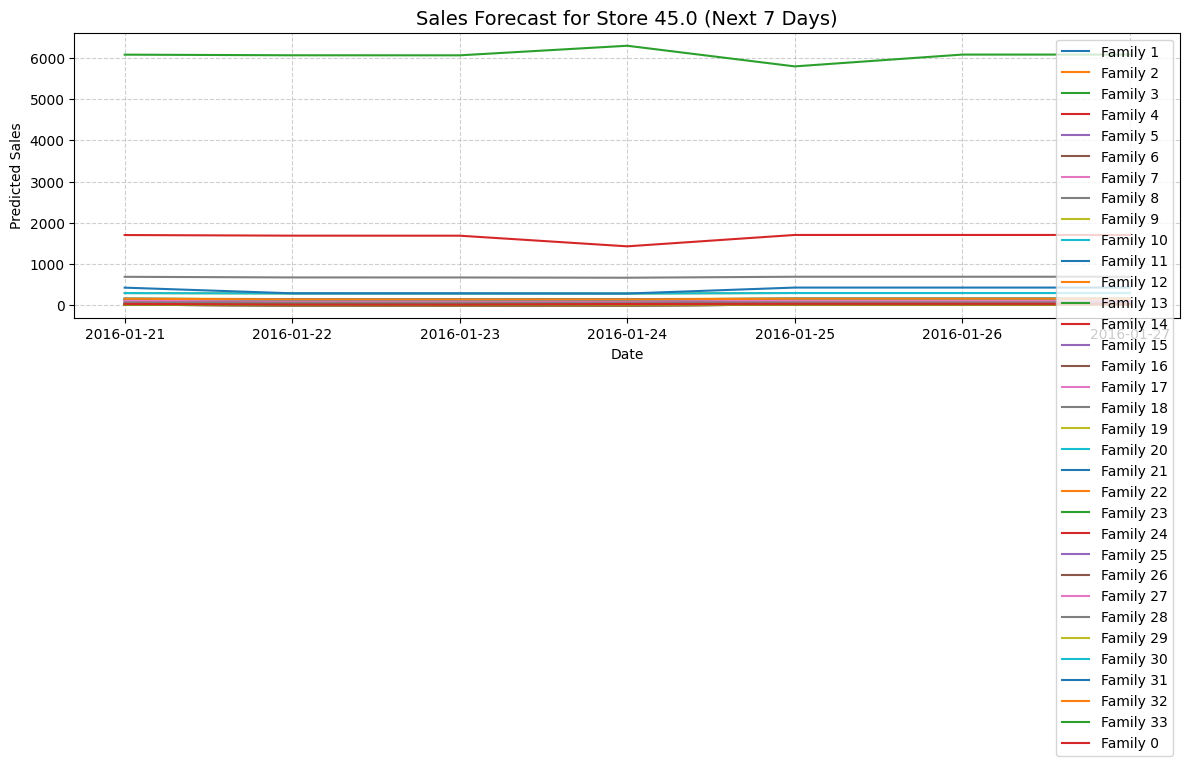

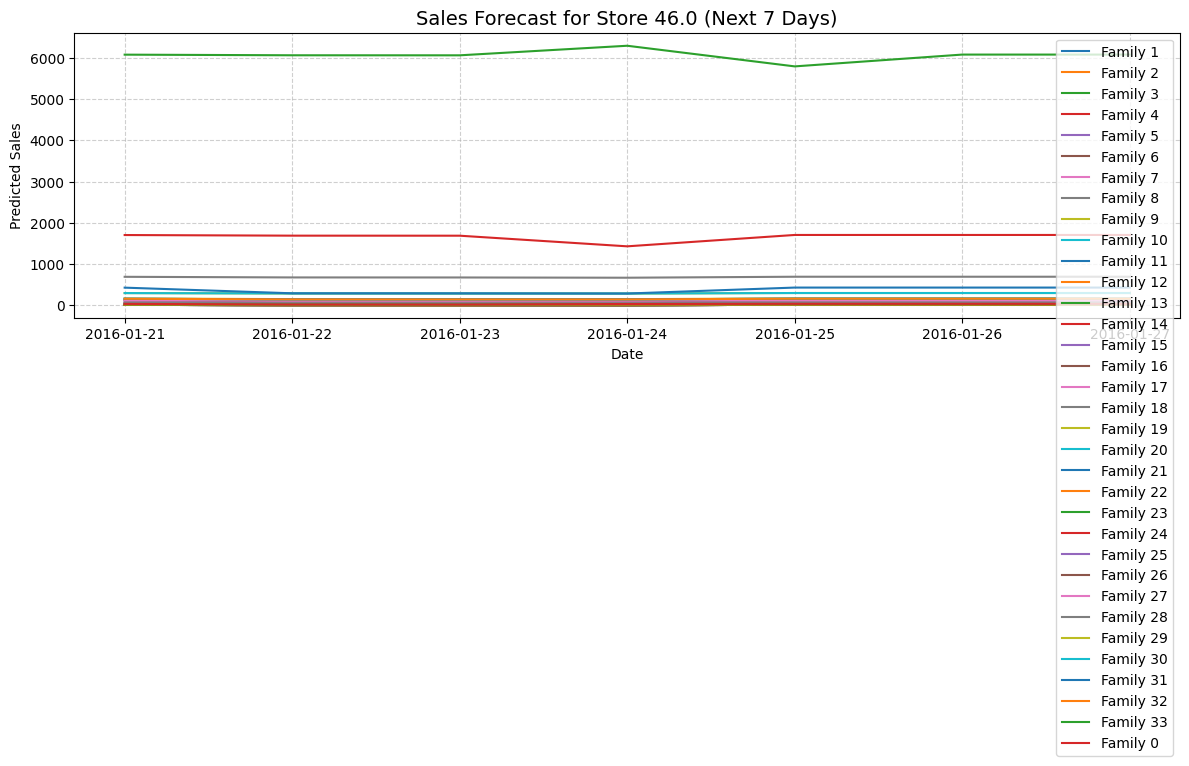

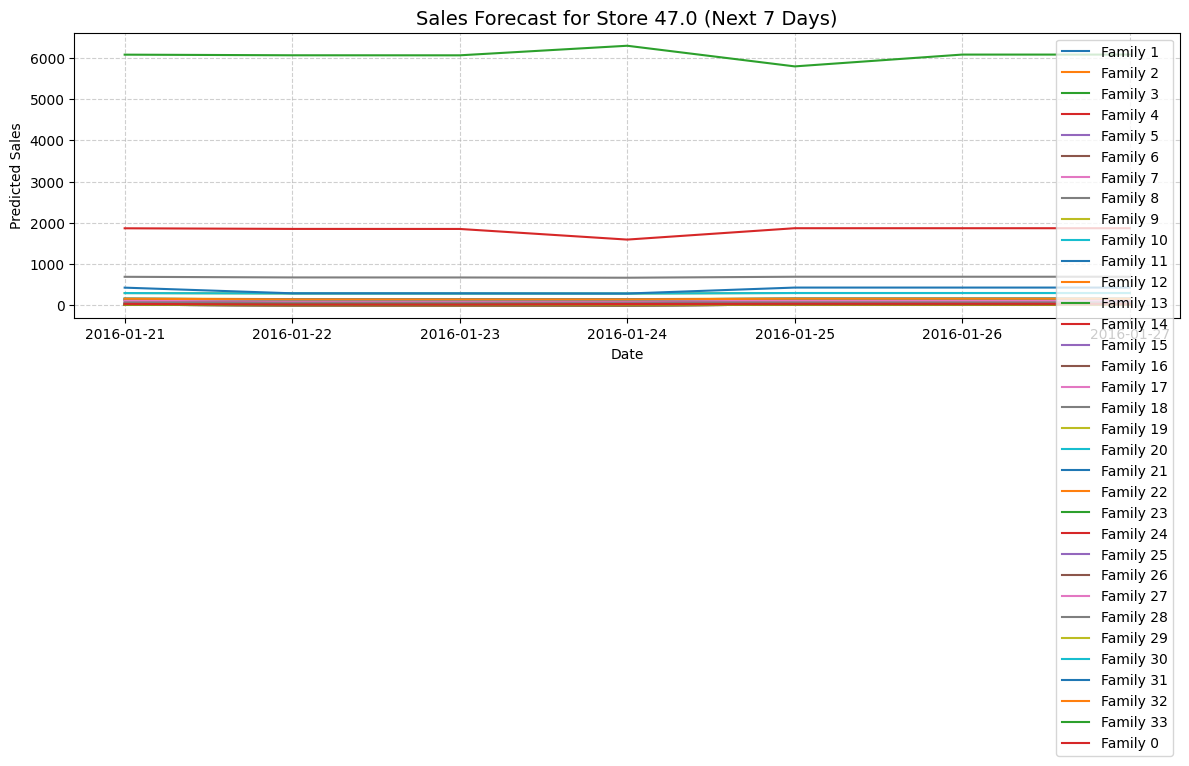

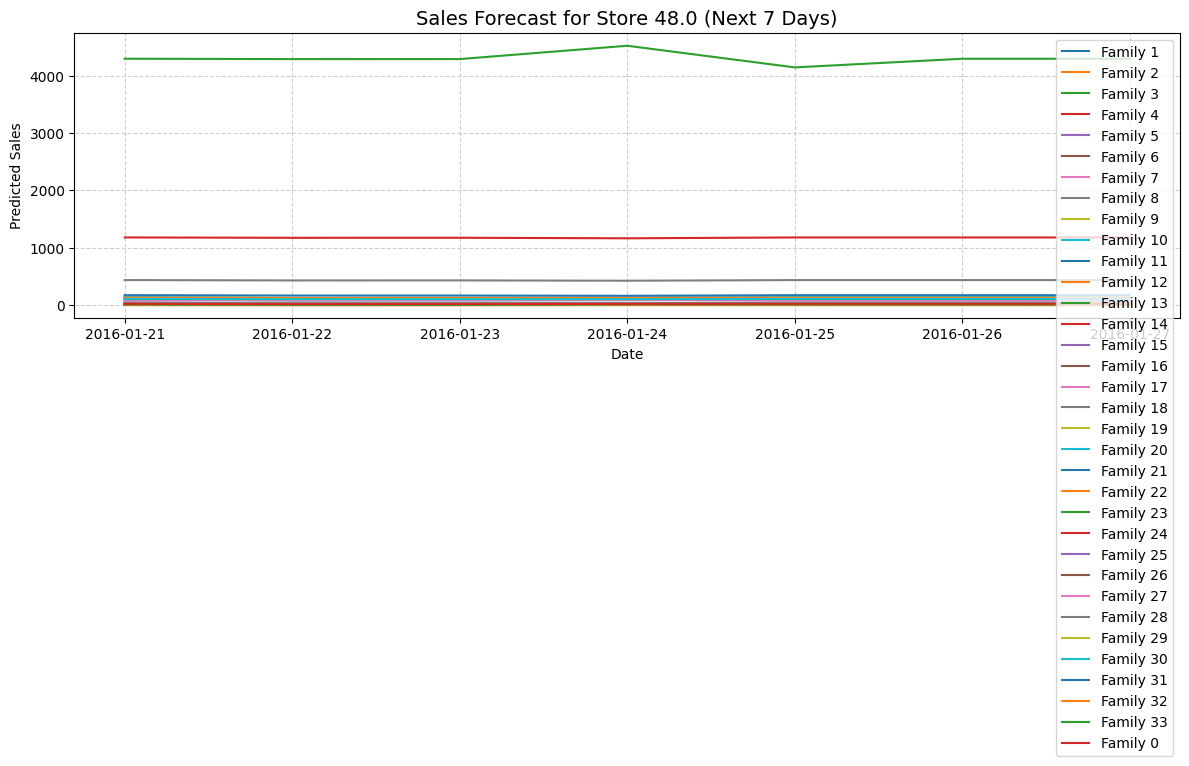

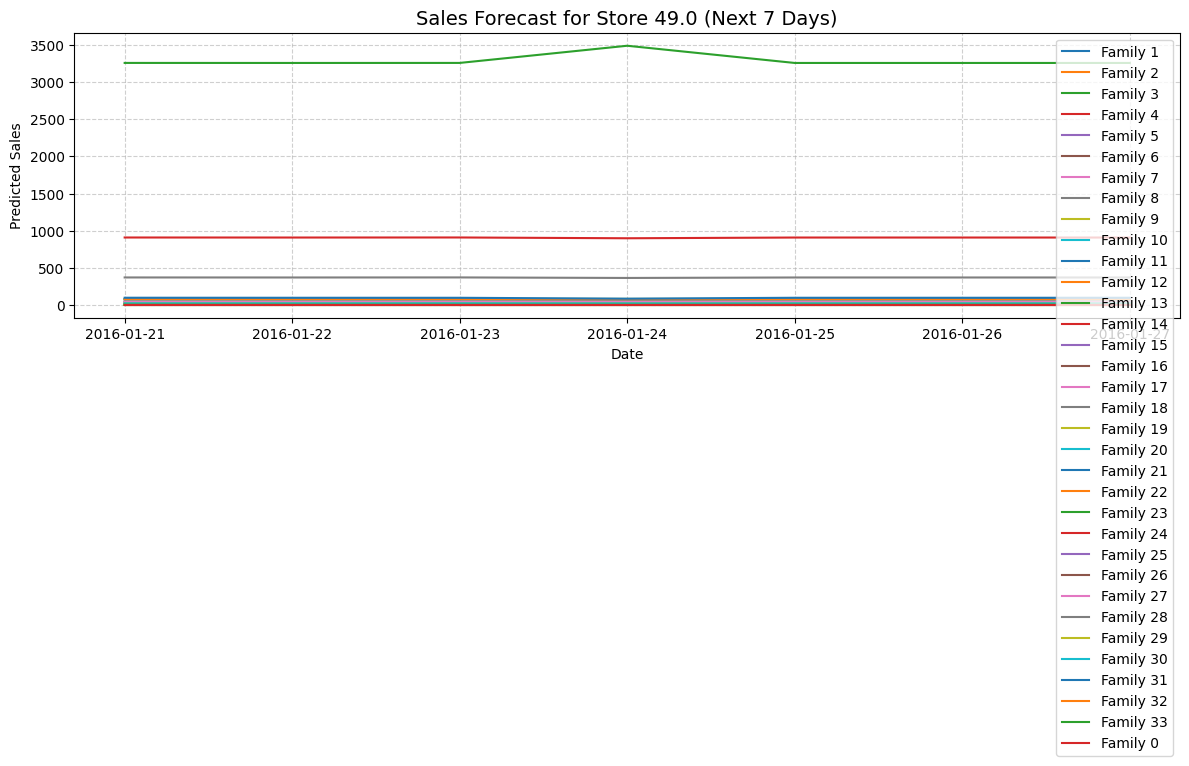

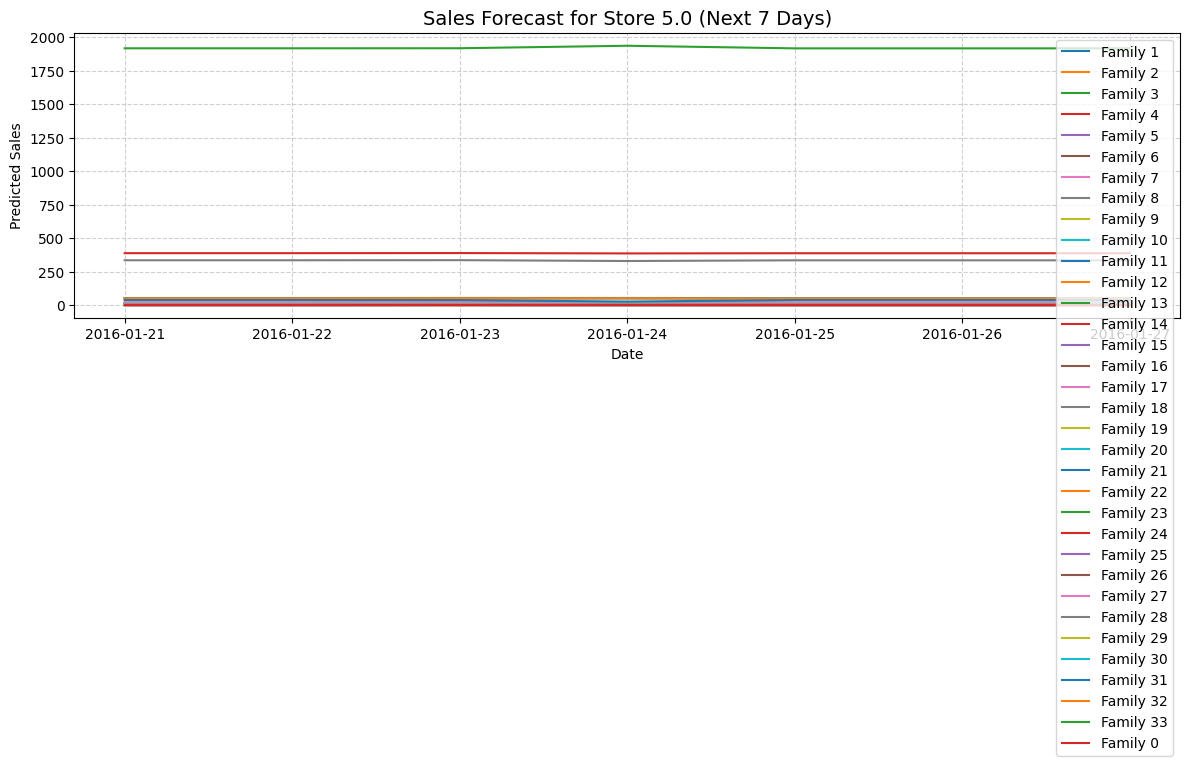

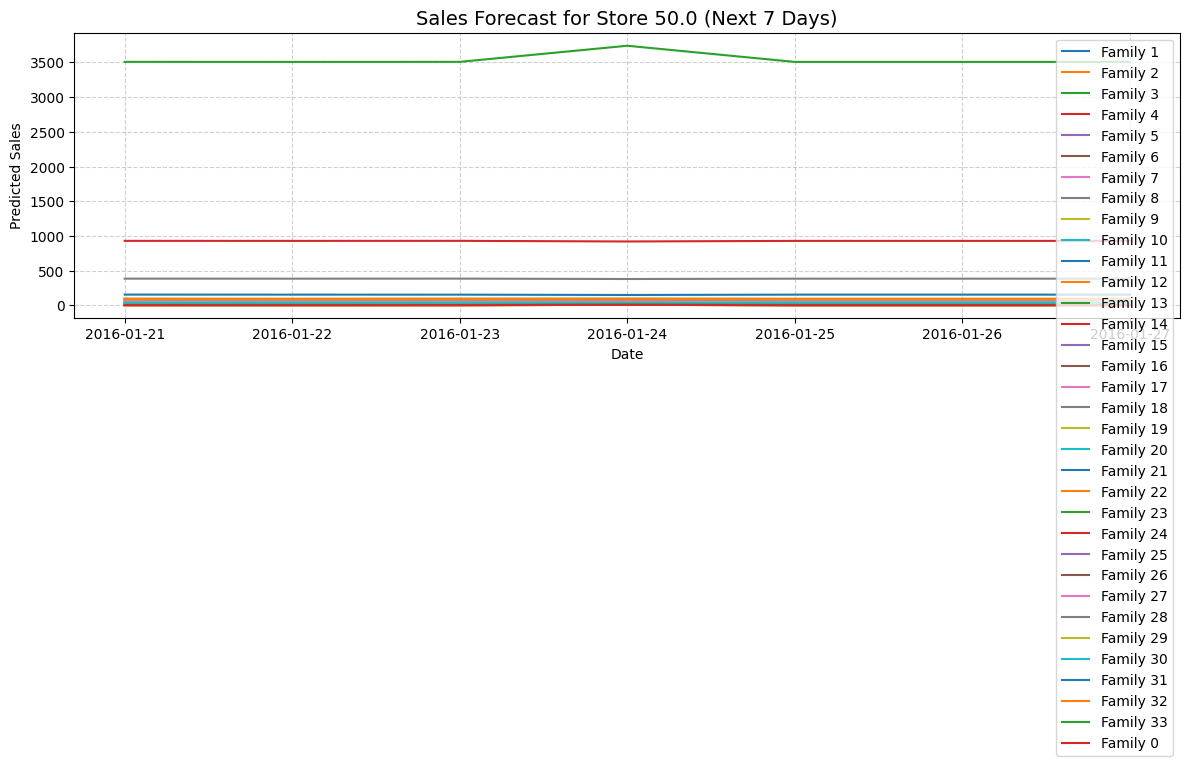

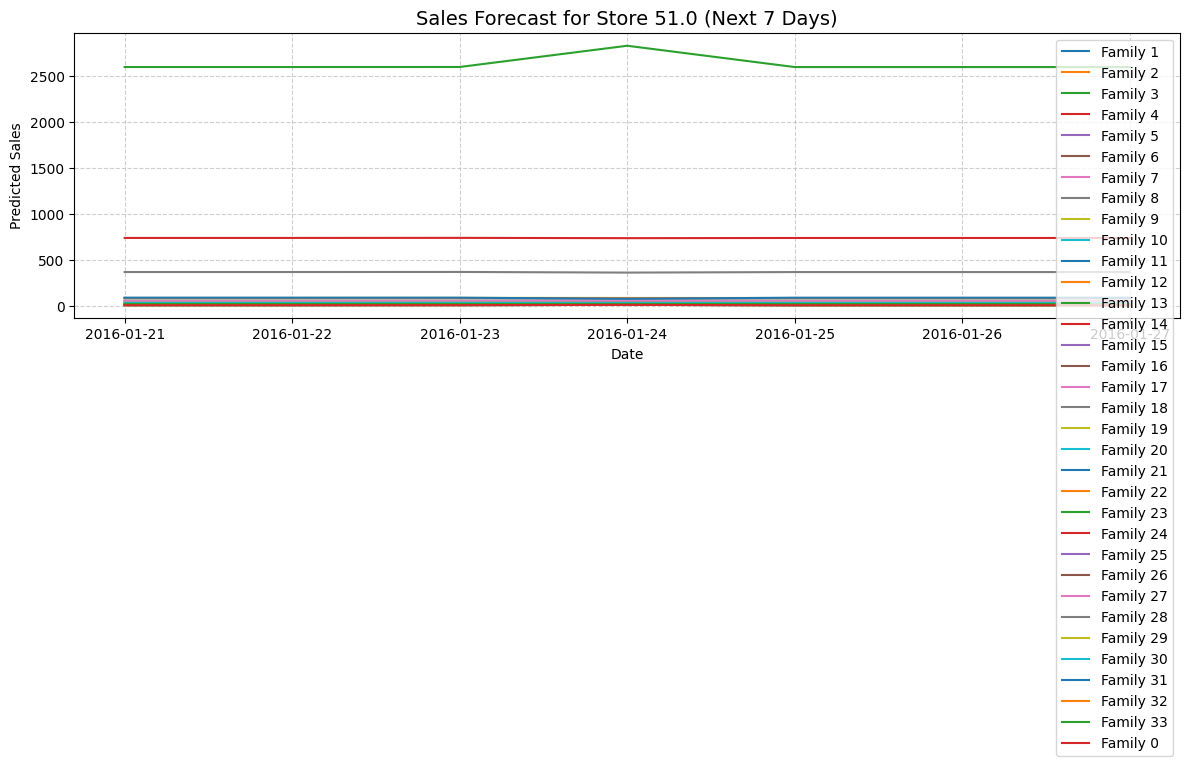

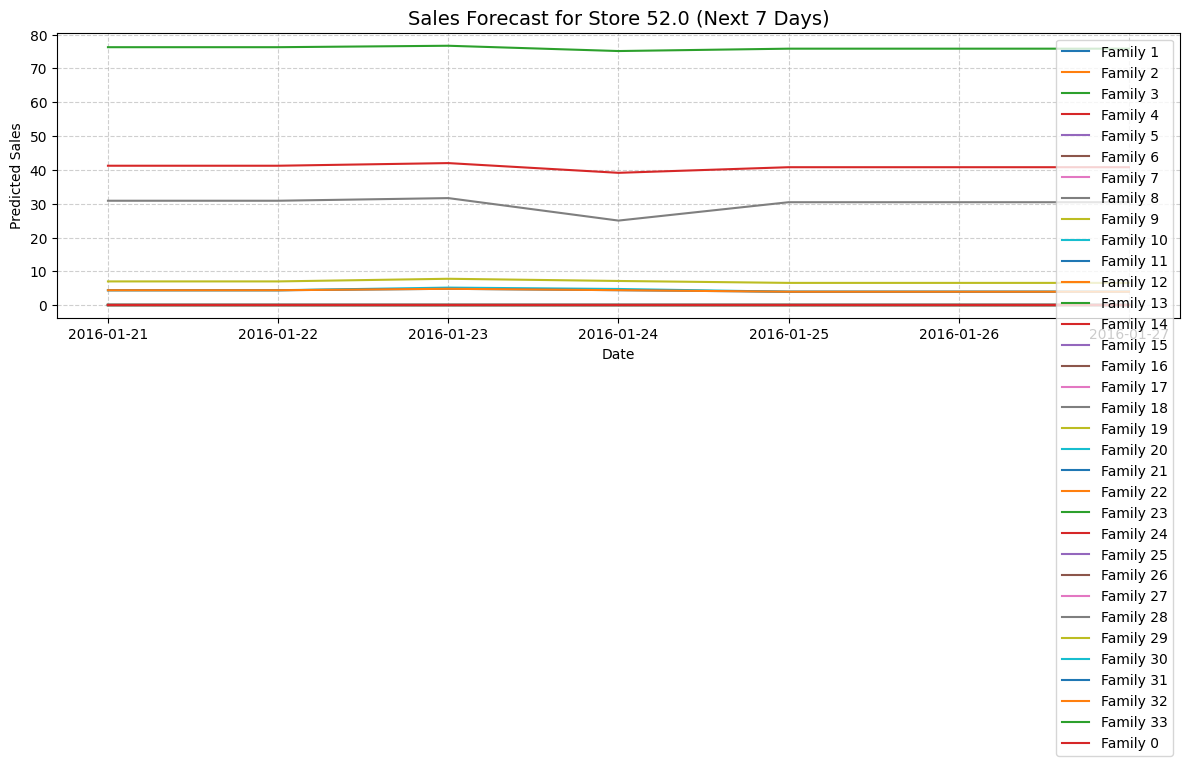

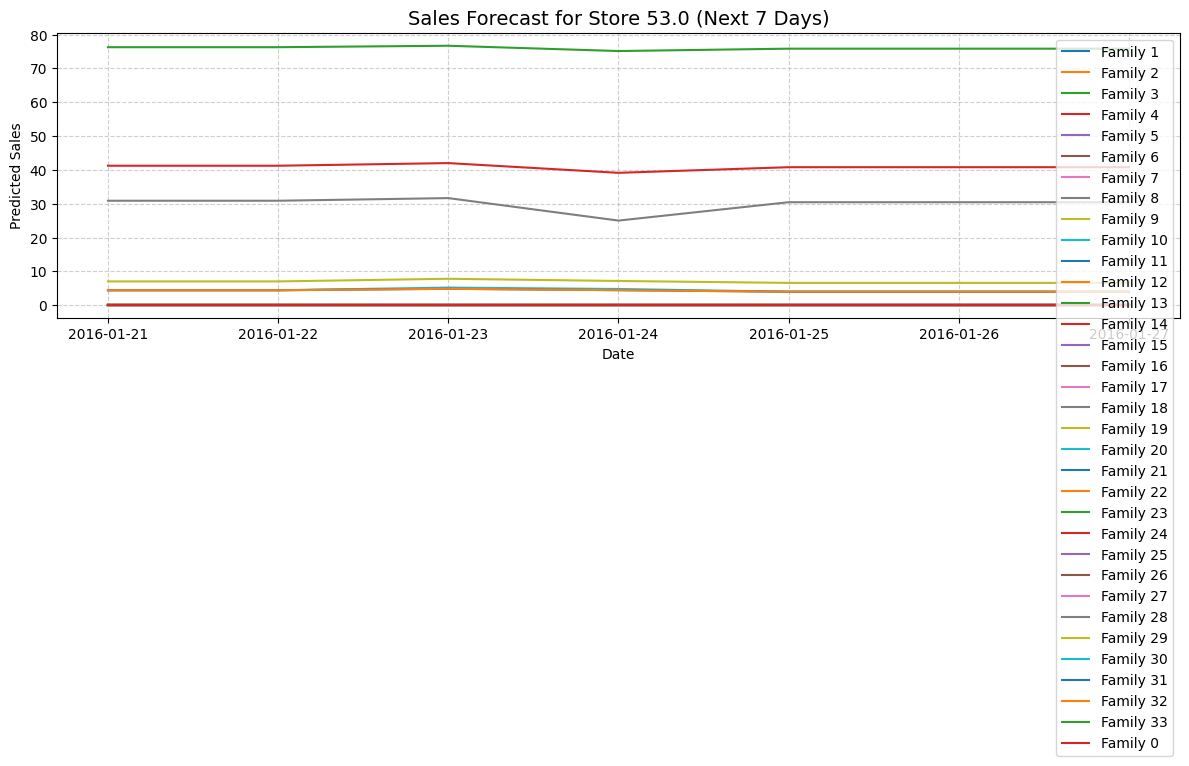

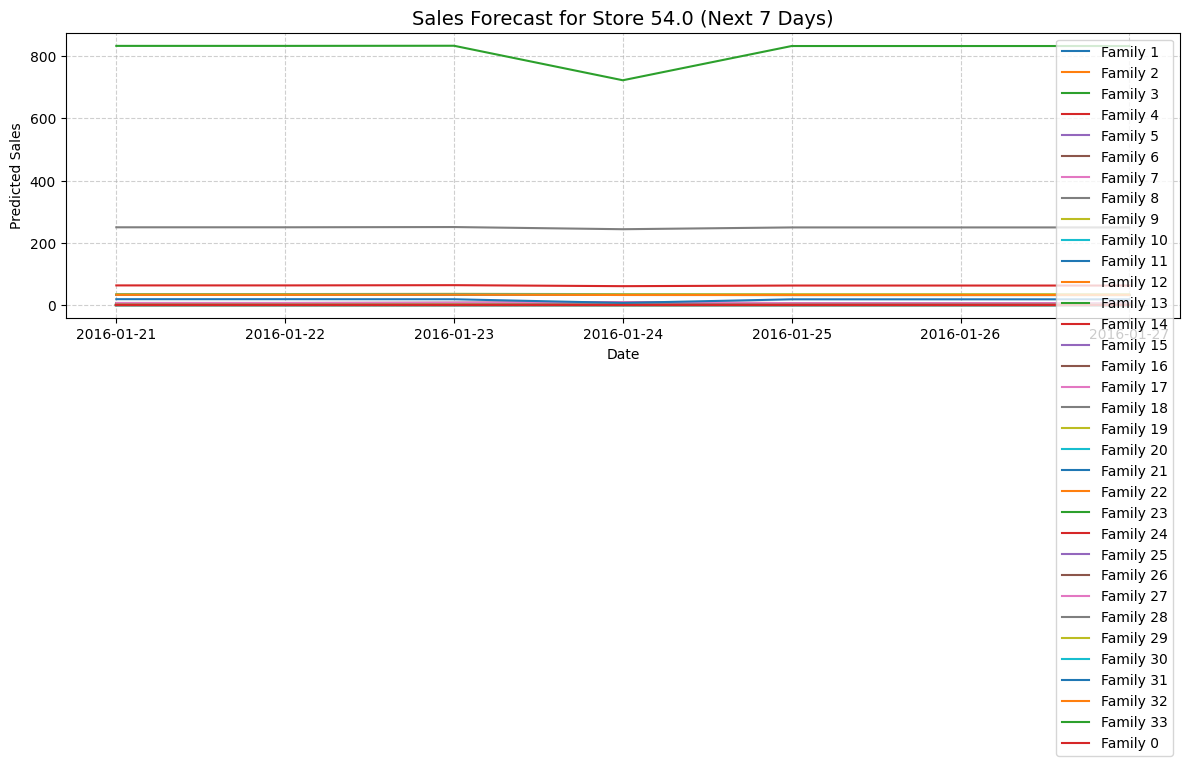

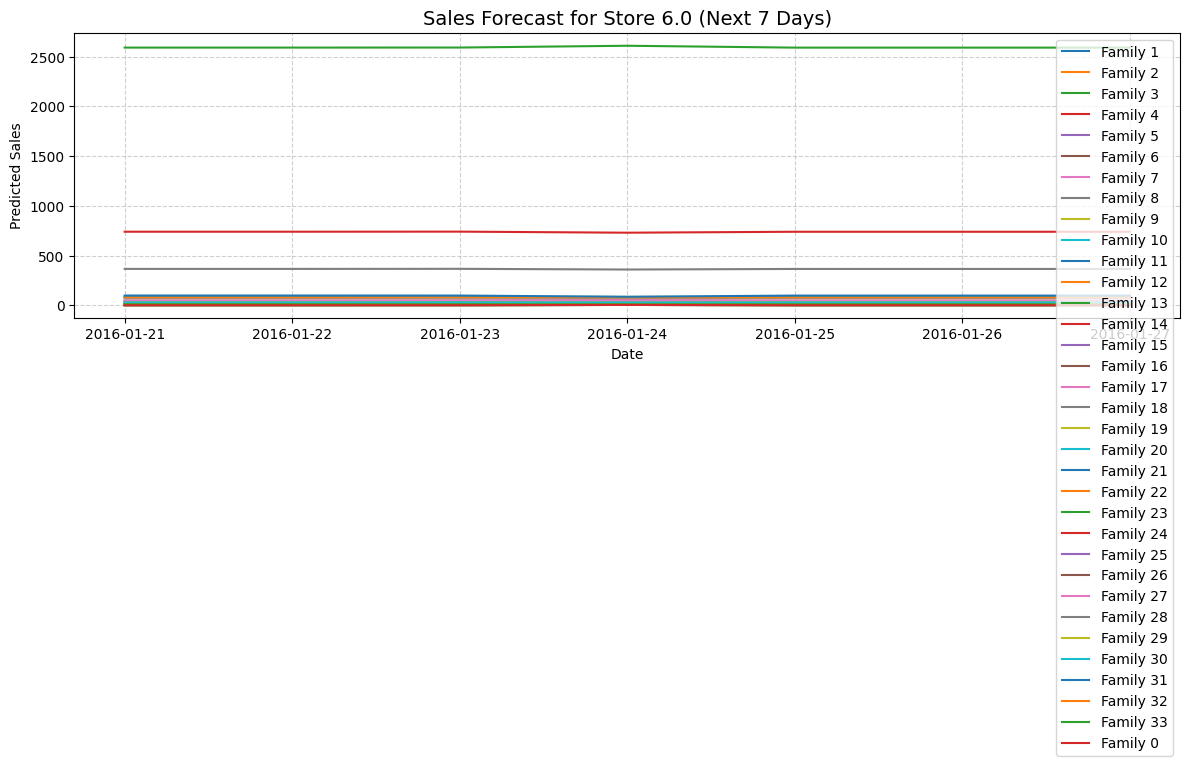

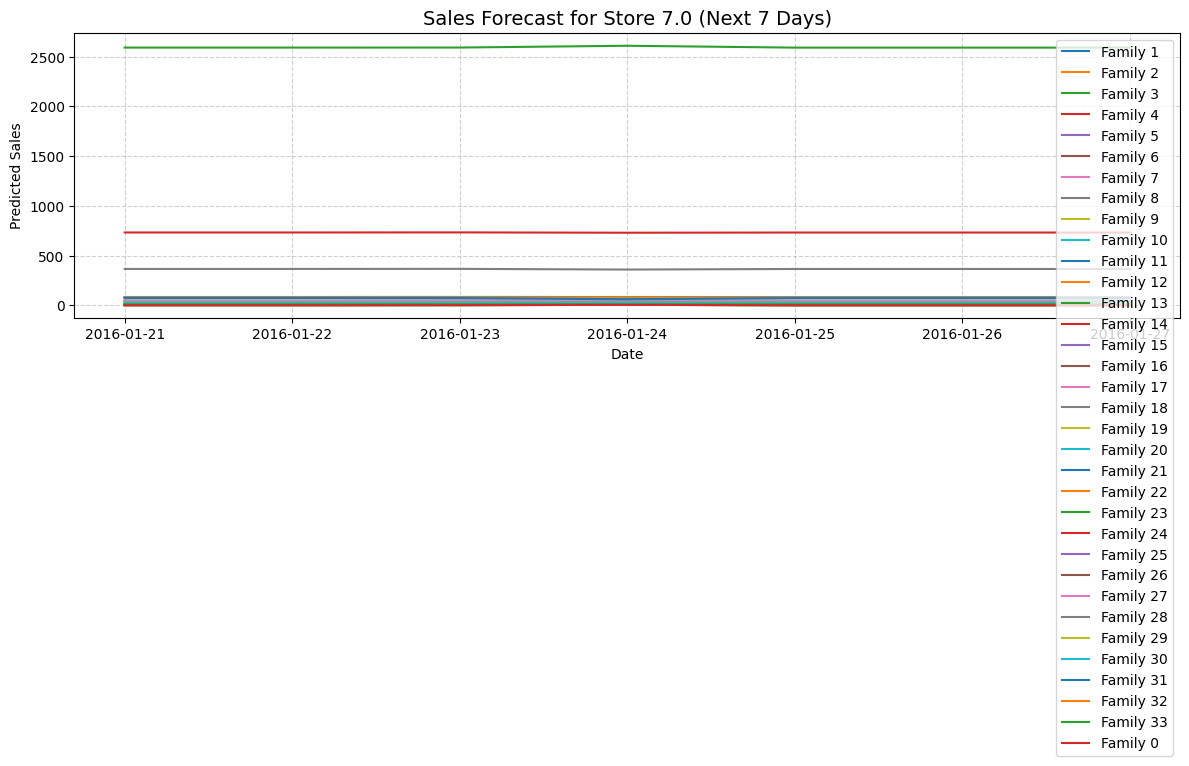

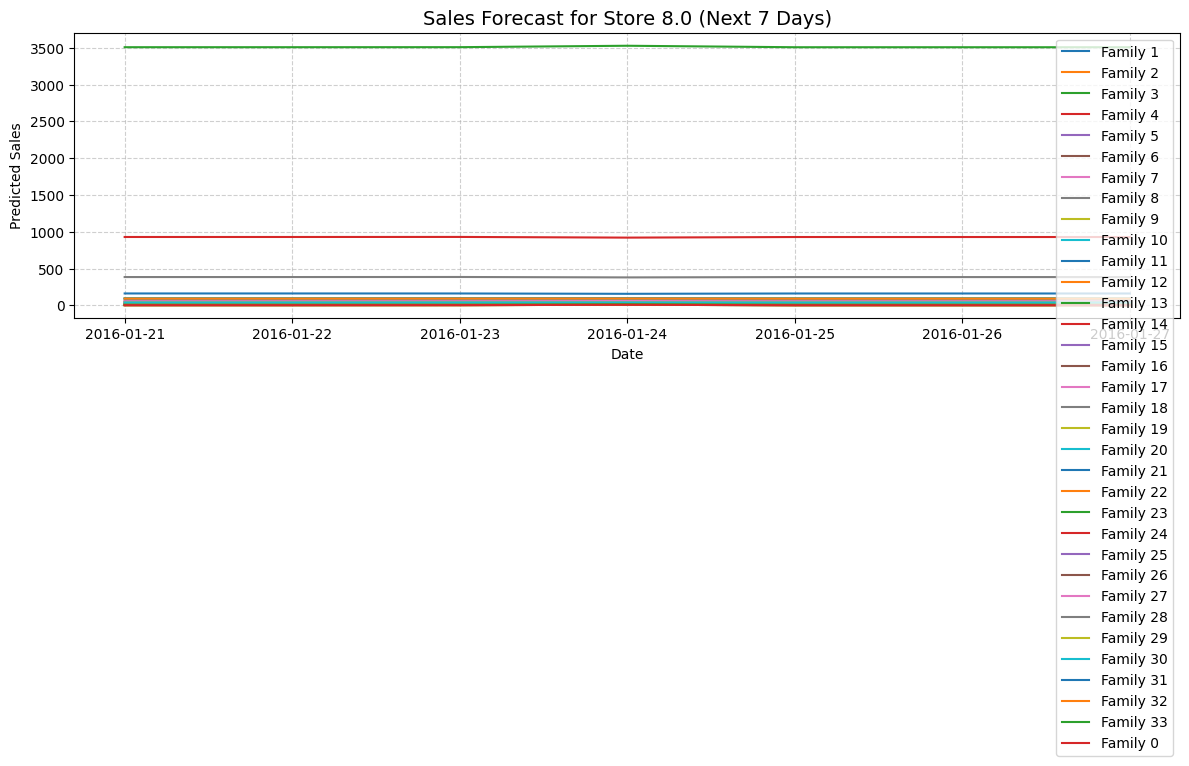

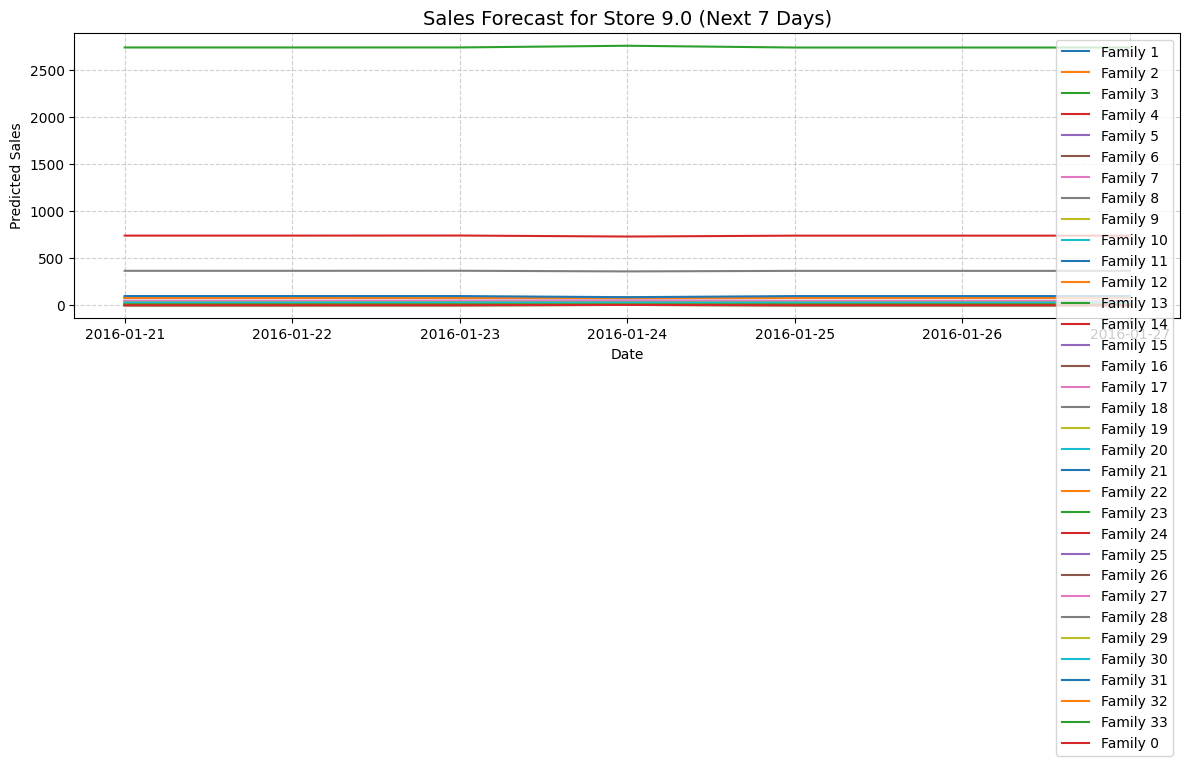

<ipython-input-64-1e9e293f77c6>:15: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



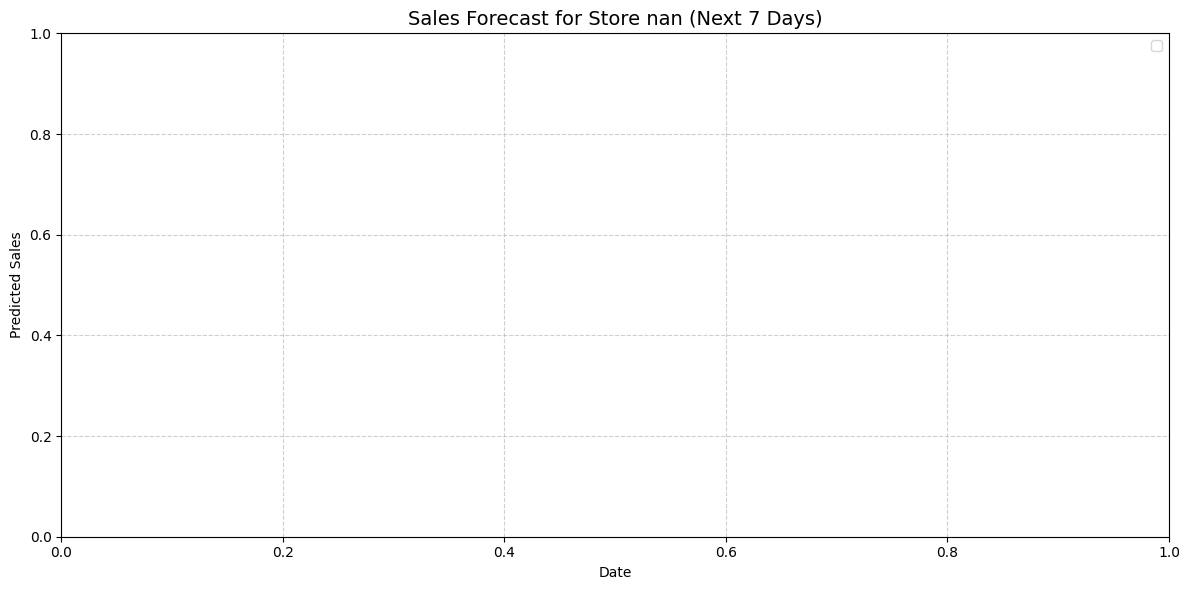

In [ ]:
# Plot forecast for each store
import matplotlib.pyplot as plt

for store in forecast_df['store_nbr'].unique():
    store_data = forecast_df[forecast_df['store_nbr'] == store]
    plt.figure(figsize=(12, 6))

    for family in store_data['family'].unique():
        family_data = store_data[store_data['family'] == family]
        plt.plot(family_data['date'], family_data['predicted_sales'], label=f'Family {family}')

    plt.title(f'Sales Forecast for Store {store} (Next 7 Days)', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel('Predicted Sales')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [ ]:
for store in forecast_df['store_nbr'].unique():
    print(f"\n📍 Store {store} Sales Forecast (Next 7 Days):\n")
    store_data = forecast_df[forecast_df['store_nbr'] == store]
    for family in store_data['family'].unique():
        family_data = store_data[store_data['family'] == family]
        total_predicted = family_data['predicted_sales'].sum()
        print(f"  - Product Family {family}: {int(total_predicted)} units forecasted")



📍 Store 1.0 Sales Forecast (Next 7 Days):

  - Product Family 1: 0 units forecasted
  - Product Family 2: 0 units forecasted
  - Product Family 3: 0 units forecasted
  - Product Family 4: 2747 units forecasted
  - Product Family 5: 166 units forecasted
  - Product Family 6: 190 units forecasted
  - Product Family 7: 190 units forecasted
  - Product Family 8: 2373 units forecasted
  - Product Family 9: 420 units forecasted
  - Product Family 10: 402 units forecasted
  - Product Family 11: 401 units forecasted
  - Product Family 12: 401 units forecasted
  - Product Family 13: 18010 units forecasted
  - Product Family 14: 15 units forecasted
  - Product Family 15: 15 units forecasted
  - Product Family 16: 15 units forecasted
  - Product Family 17: 15 units forecasted
  - Product Family 18: 15 units forecasted
  - Product Family 19: 15 units forecasted
  - Product Family 20: 15 units forecasted
  - Product Family 21: 15 units forecasted
  - Product Family 22: 15 units forecasted
  - Prod